In [1]:
# Base ------------------------------------------------
import numpy as np
import pandas as pd
import scipy.stats as ss
import statsmodels.stats.weightstats as smw
import math
import plotly.express as px

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.float_format = '{:.1f}'.format

#plt.style.use('seaborn')
# Viz -------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
import plotly.express as px

# Estimation and Models -------------------------------------
import statsmodels.stats.proportion as smp       # Estimation of proportions
import statsmodels.stats.weightstats as smw      # Estimation of the Mean
from statsmodels.stats.power import TTestPower   # Power of the Test

# Standard Library Imports
from pathlib import Path

from plotnine import *

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

from plotnine import *
plt.style.use('ggplot')

In [7]:
df = pd.read_parquet('Data raw.parquet')

In [8]:
df.shape

(226516, 27)

Columns surface, price, room, category, bathroom, elevator_flag, other_features, typology - have zero empty values, hence we can assume has dirrect connection to a property value.

In [9]:
rows, columns = df.shape
cell_count = rows * columns
number_of_nulls = df.isnull().sum().sum()
percentage_of_missing = (number_of_nulls / cell_count) * 100
print(f'Percentage of missing values: {percentage_of_missing}%')

Percentage of missing values: 9.481122419281313%


Relationship between values being missing and price.
Let's evaluate the price of the house in those observations where the information is missing, for each variable.
1 - value is missing
0 - value is pressent

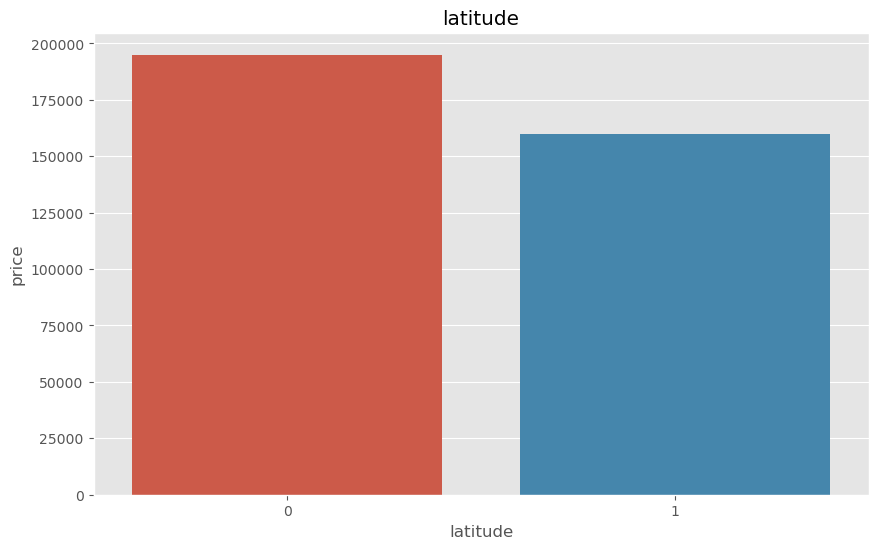

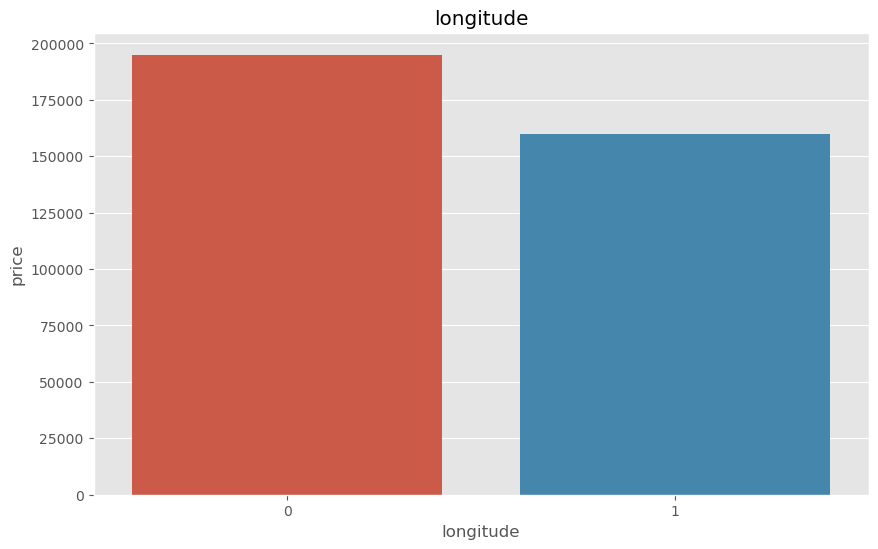

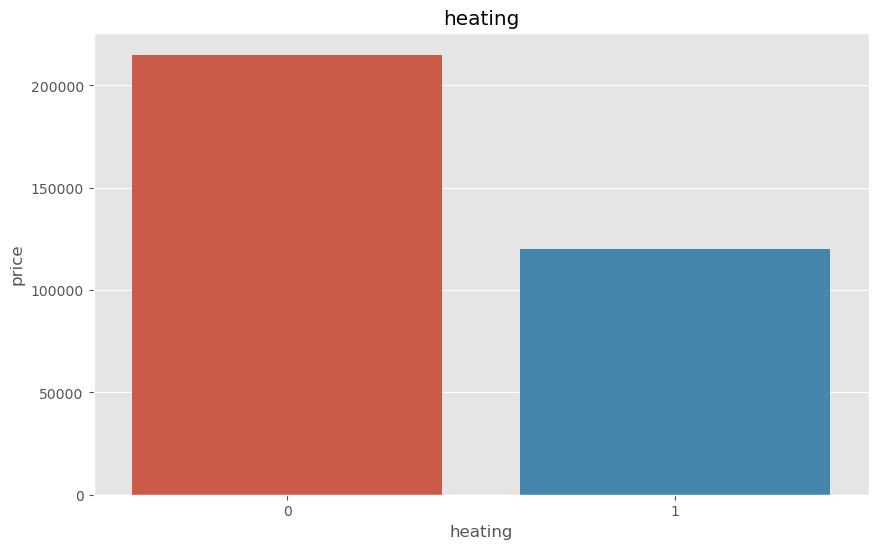

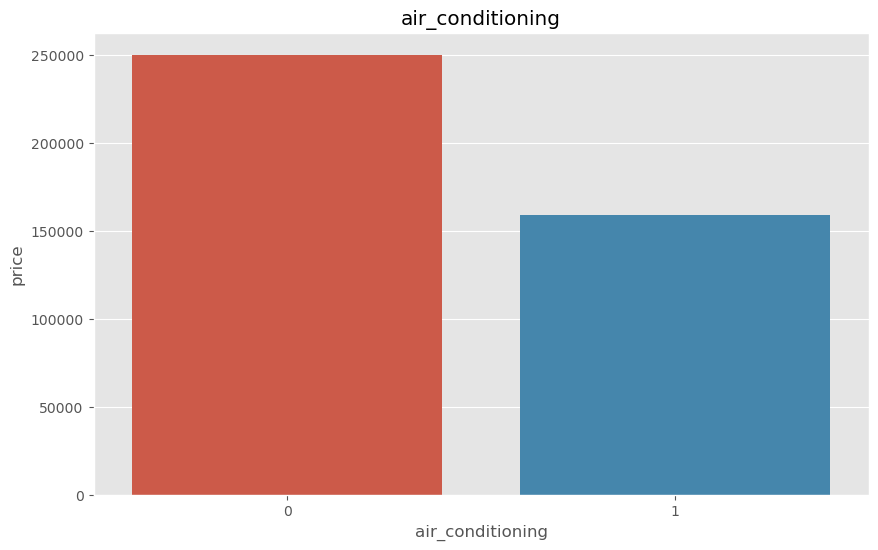

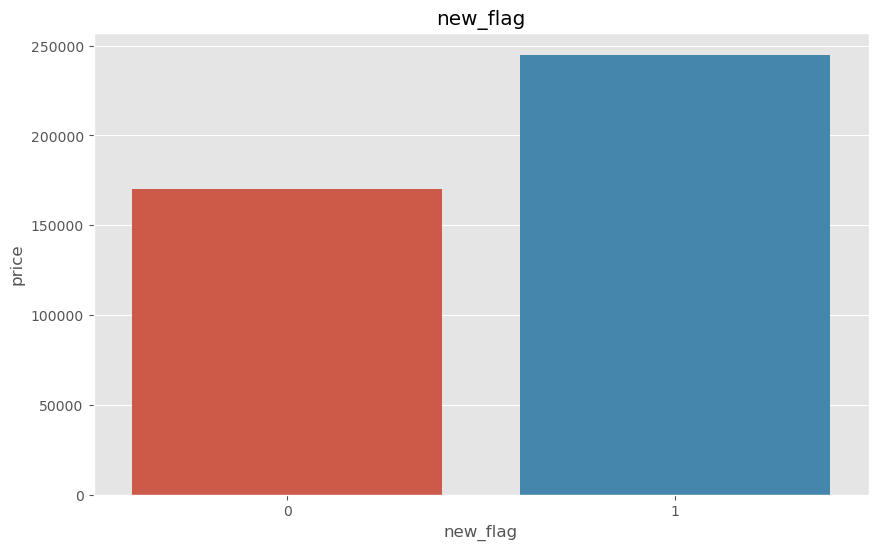

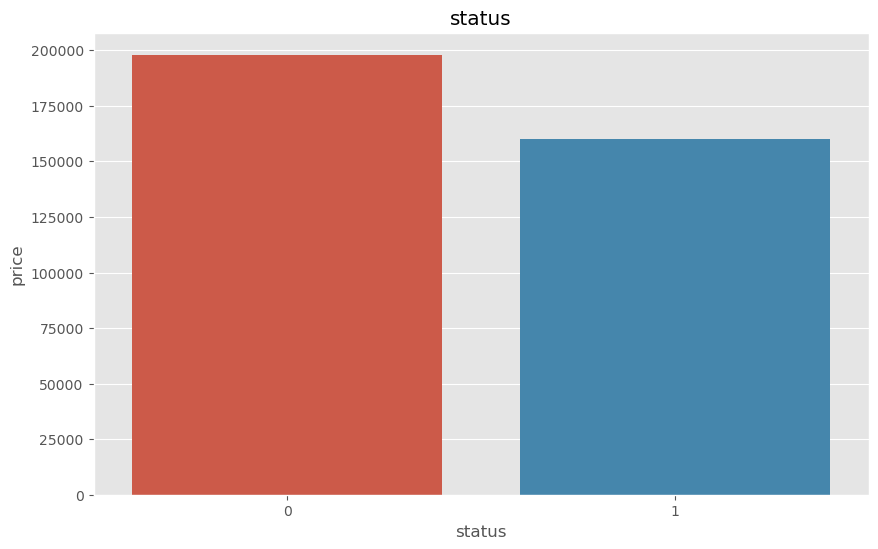

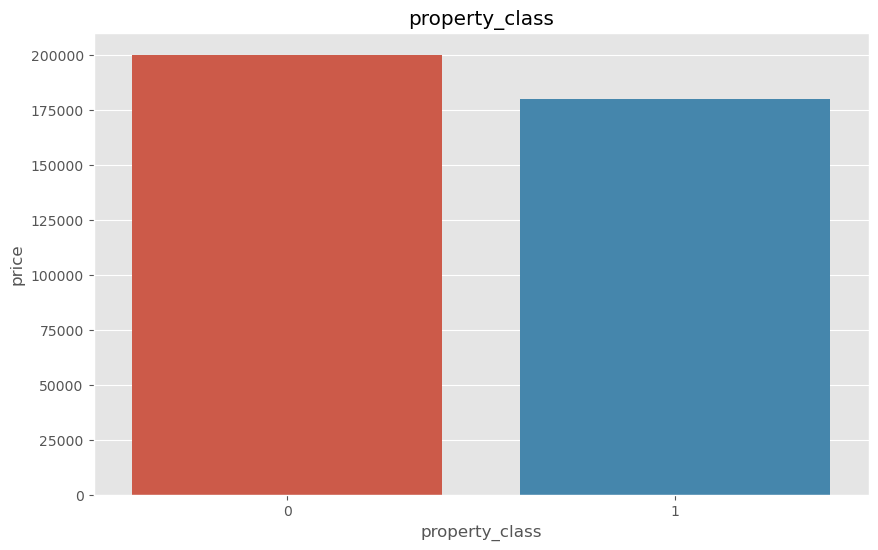

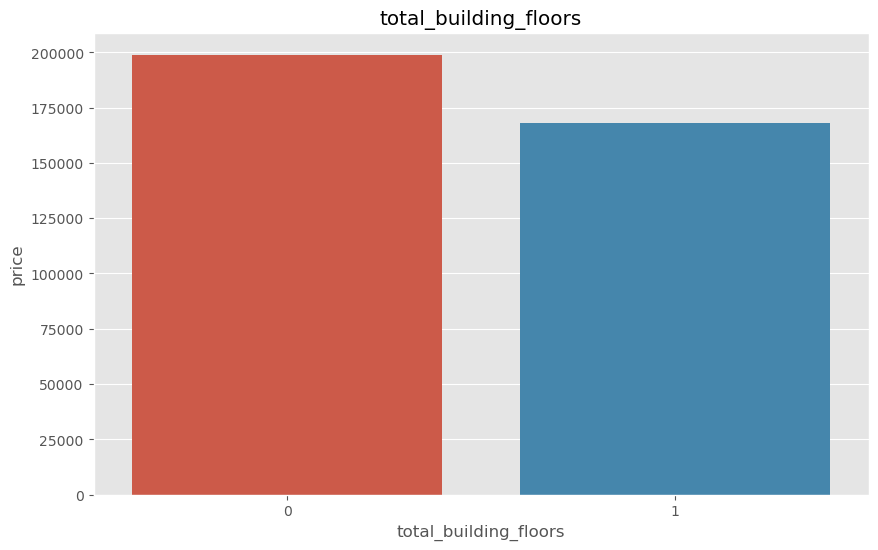

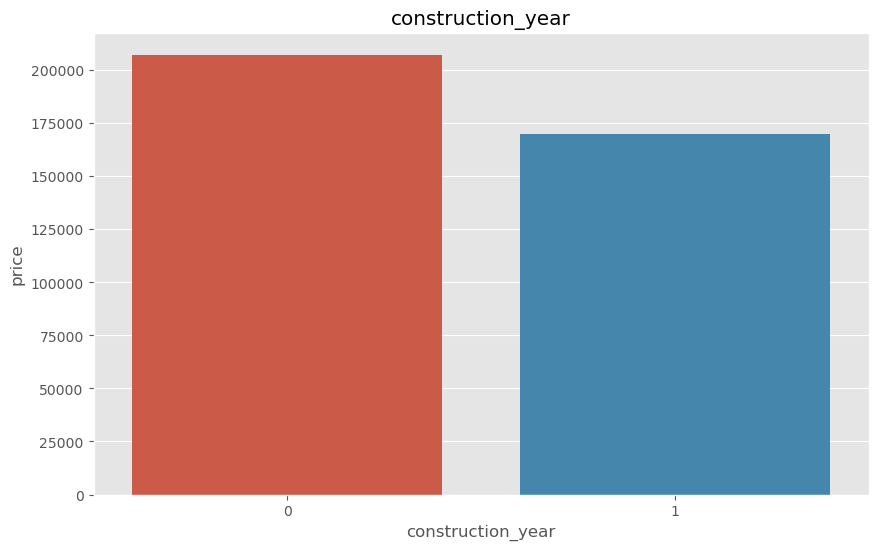

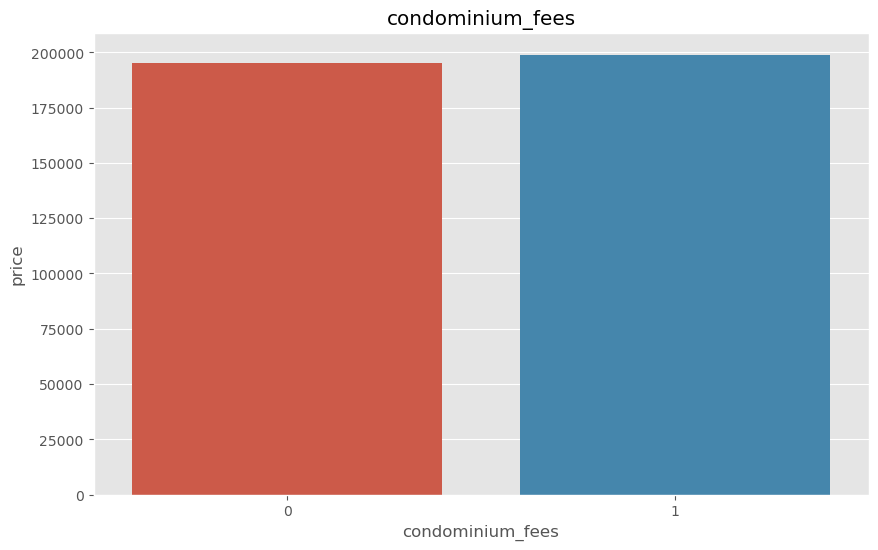

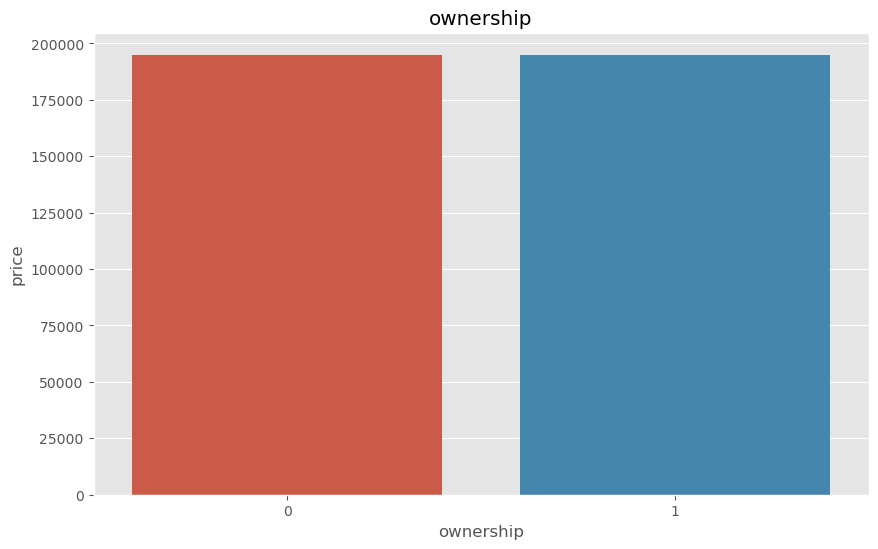

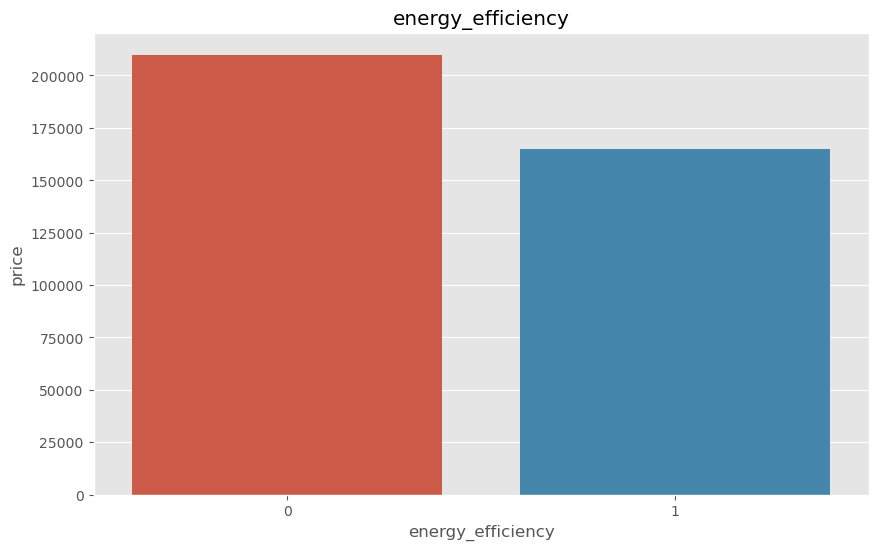

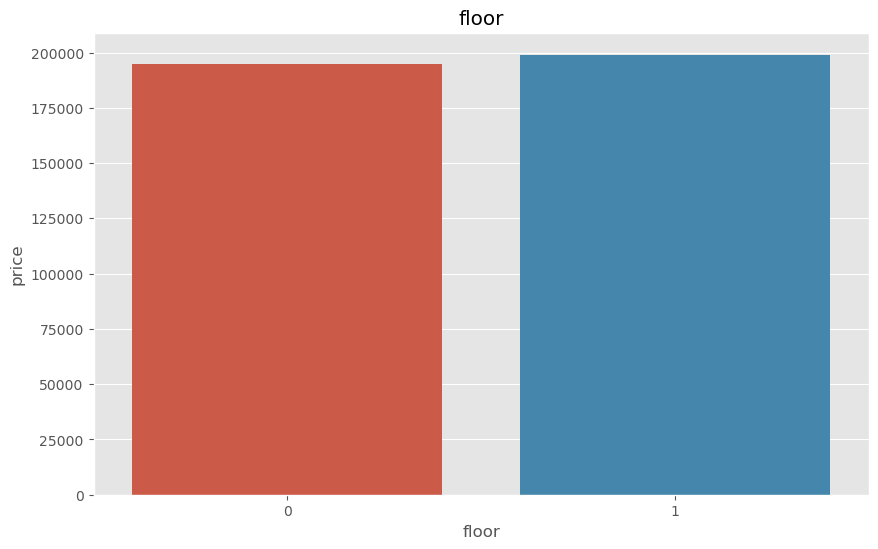

In [10]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in df.columns if df[var].isnull().sum() > 0]
df[vars_with_na].isnull().mean()
def analyse_na_value(df, var):
    df = df.copy()
    # let's make a variable that indicates 1 if the observation was missing or zero otherwise
    df[var] = np.where(df[var].isna(), 1, 0)
    grs = df.groupby(var)['price'].median().reset_index()
    plt.figure(figsize=(10,6))
    sns.barplot(x=grs[var], y=grs['price'])
    plt.title(var)
    plt.show()


# let's run the function on each variable with missing data
for var in vars_with_na:
    analyse_na_value(df, var)

In [11]:
# Selecting duplicate rows except first
# occurrence based on all columns
duplicates = df[df.duplicated()]
 
print("Duplicated Rows :")
len(duplicates)

Duplicated Rows :


2

In [12]:
df.drop_duplicates(keep='first', inplace=True)

In [13]:
# Drop pictures and description per client suggestion
df = df.drop(columns=['main_photo_url', 'description'])

In [14]:
#Geographical range = Italy
# create a boolean mask based on latitude and longitude range for Italy
italy_lat_range = (35.5, 47.1)
italy_lon_range = (6.6, 18.5)
mask = (df['latitude'].between(*italy_lat_range)) & (df['longitude'].between(*italy_lon_range))
df = df[mask]

In [15]:
df.shape

(223714, 25)

In [16]:
'''remove based on property type
-Open space
-Office
-Garage
-Shop
- Agricultural land
-Nuraghe
''' 
df = df.drop(df[(df['typology'] == 'Open space') | (df['typology'] == 'Office') | (df['typology'] == 'Nuraghe')| (df['typology'] == 'Agricultural land') | (df['typology'] == 'Garage') | (df['typology'] == 'Shop')].index)

In [17]:
df.shape

(223515, 25)

In [18]:
# Replace empty rows with NaN value
df = df.replace('', np.nan).replace(' ', np.nan)
# Replace all None values with NaN
df = df.replace({None: np.nan})
df.head(3)

,latitude,longitude,heating,air_conditioning,surface,new_flag,status,caption,price,room,property_class,category,total_building_floors,bathroom,elevator_flag,construction_year,title,condominium_fees,ownership,other_features,energy_efficiency,floor_text,floor,typology,visibility
0,37.6,15.0,Autonomo,NaN,200 m²,0.0,Excellent condition / Renovated,Villa o villino in vendita a Mascalucia,310000,5+,Mid-range properties,Residential,3.0,3,0,NaN,Villa unifamiliare via Busoni 5 Centro Mascalucia,0.0,Full ownership,"['Balcone', 'Giardino privato']",NaN,Su più livelli,NaN,Single-family villa,premium
1,37.6,15.1,NaN,NaN,300 m²,0.0,Needs renovation,Villa a Ficarazzi con ampio spazio esterno e l...,329000,5+,Luxury properties,Residential,2.0,2,0,1895.0,Villa unifamiliare via Tripoli 145 95021 Aci C...,0.0,Full ownership,"['Balcone', 'Terrazza', 'Impianto tv singolo',...",G,Piano terra,0.0,Single-family villa,premium
2,37.5,15.1,Autonomo,"Autonomo, freddo/caldo","148 m² | commerciale 174,5 m²",0.0,Excellent condition / Renovated,Zona Ognina Indipendente con garage e spazio e...,330000,4,Mid-range properties,Residential,2.0,3,0,2000.0,Villa unifamiliare via Veglia 10 Picanello Cat...,0.0,Full ownership,"['Cancello elettrico', 'Caminetto', 'VideoCito...",E,2 piani: da Seminterrato a Piano terra,0.0,Single-family villa,premium


In [19]:
df.head(3)

,latitude,longitude,heating,air_conditioning,surface,new_flag,status,caption,price,room,property_class,category,total_building_floors,bathroom,elevator_flag,construction_year,title,condominium_fees,ownership,other_features,energy_efficiency,floor_text,floor,typology,visibility
0,37.6,15.0,Autonomo,NaN,200 m²,0.0,Excellent condition / Renovated,Villa o villino in vendita a Mascalucia,310000,5+,Mid-range properties,Residential,3.0,3,0,NaN,Villa unifamiliare via Busoni 5 Centro Mascalucia,0.0,Full ownership,"['Balcone', 'Giardino privato']",NaN,Su più livelli,NaN,Single-family villa,premium
1,37.6,15.1,NaN,NaN,300 m²,0.0,Needs renovation,Villa a Ficarazzi con ampio spazio esterno e l...,329000,5+,Luxury properties,Residential,2.0,2,0,1895.0,Villa unifamiliare via Tripoli 145 95021 Aci C...,0.0,Full ownership,"['Balcone', 'Terrazza', 'Impianto tv singolo',...",G,Piano terra,0.0,Single-family villa,premium
2,37.5,15.1,Autonomo,"Autonomo, freddo/caldo","148 m² | commerciale 174,5 m²",0.0,Excellent condition / Renovated,Zona Ognina Indipendente con garage e spazio e...,330000,4,Mid-range properties,Residential,2.0,3,0,2000.0,Villa unifamiliare via Veglia 10 Picanello Cat...,0.0,Full ownership,"['Cancello elettrico', 'Caminetto', 'VideoCito...",E,2 piani: da Seminterrato a Piano terra,0.0,Single-family villa,premium


In [20]:
#surface 
df.surface.replace(' m²','', regex=True, inplace=True)
df.surface.replace(' |','', regex=True, inplace=True)

df = df[df['surface'].str.contains('commerciale', case=False) == False]
df['surface'] = df['surface'].str.replace('.', '').astype(float)

C:\Users\kater\AppData\Local\Temp\ipykernel_18008\3925688788.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [21]:
#normalizing
df = df[(df['price'] > 0) & df['price'].notna()]
df = df[(df['surface'] > 0) & df['surface'].notna()]
df = df[(df['latitude'] >= 0) & df['latitude'].notna()]
df = df[(df['longitude'] >= 0) & df['longitude'].notna()]

In [22]:
# Load Market data
Italy_df = pd.read_excel('worldcities.xlsx', sheet_name='Italy2')

In [23]:
# Select only the regions from the Geo file
regions = Italy_df[['admin_name','latmin', 'latmax', 'logmin', 'logmax']]
regions = regions.drop_duplicates()

In [24]:
# *Create Regional column*
# Iterate over the coordinates in your original DataFrame
for index, row in df.iterrows():
    lat = row['latitude']
    lon = row['longitude']

    # Find the region that matches the coordinate range
    matching_region = regions[
        (regions['latmin'] <= lat) &
        (regions['latmax'] >= lat) &
        (regions['logmin'] <= lon) &
        (regions['logmax'] >= lon)
    ]['admin_name']
    
   # Check if matching_region has any elements
    if not matching_region.empty:
        # Get the first element of matching_region as a string
        matching_region = matching_region.iloc[0]
    else:
        matching_region = 'Unknown'  # or any other desired value when no match is found
        
    # Assign the region to a new column in your original DataFrame
    df.at[index, 'Region'] = matching_region

## Price 

In [25]:
df['price_per_m2'] = df.apply(lambda x: round(x['price'] / x['surface'], 2) if x['surface'] else 0, axis=1)

In [26]:
df = df[(df['price_per_m2'] > 0.99) & (df['price_per_m2'] <= 7822)]
#df = df[(df['surface_res'] > 0.99) & (df['surface_res'] <= 1000)]

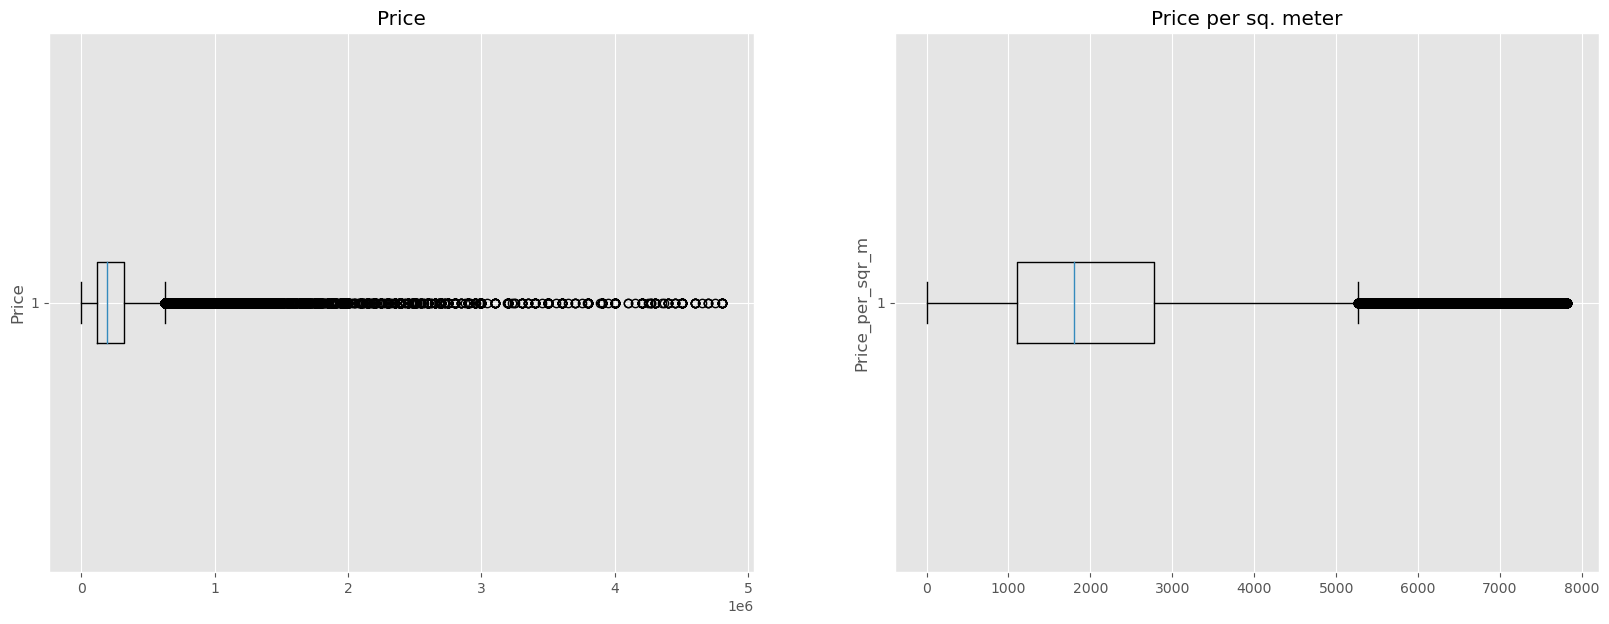

In [28]:
# create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))

# create boxplots on each subplot
ax1.boxplot(df['price'], vert=False)
ax2.boxplot(df['price_per_m2'], vert = False)

# set titles and labels for each subplot
ax1.set_title('Price')
ax1.set_ylabel('Price')
ax2.set_title('Price per sq. meter')
ax2.set_ylabel('Price_per_sqr_m')

# show the plot
plt.show()

In [29]:
df = df[(df['total_building_floors'] >= 0) & (df['total_building_floors'] <= 10)]

In [30]:
#Replace NaNs with median values
df['construction_year'] = df.groupby('Region')['construction_year'].transform(lambda x: x.fillna(x.median()))

C:\Users\kater\AppData\Local\Temp\ipykernel_18008\3308763527.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
# Replace Construction year > 2023 with median
const_yr = [2024, 2025, 2033, 2089, 2100, 7080, 9999]
for i in const_yr:
    df.loc[df['construction_year']==i, 'construction_year'] = df.groupby('Region')['construction_year'].transform(lambda x: x.replace(i, x.median()))

EXPLORING CORRELATION BETWEEN VARIAVLES

In [32]:
corr = df.corr()
corr

,latitude,longitude,surface,new_flag,price,total_building_floors,elevator_flag,construction_year,condominium_fees,floor,price_per_m2
0,,,,,,,,,,,
latitude,1.0,-0.7,-0.0,0.0,0.1,0.1,0.1,-0.0,0.3,0.0,0.2
longitude,-0.7,1.0,0.0,-0.0,-0.0,-0.1,-0.1,0.0,-0.2,-0.0,-0.1
surface,-0.0,0.0,1.0,-0.0,0.1,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
new_flag,0.0,-0.0,-0.0,1.0,-0.0,0.1,0.0,0.0,0.0,0.0,0.0
price,0.1,-0.0,0.1,-0.0,1.0,0.0,0.1,-0.1,0.2,-0.0,0.5
total_building_floors,0.1,-0.1,-0.0,0.1,0.0,1.0,0.6,-0.0,0.4,0.6,0.3
elevator_flag,0.1,-0.1,-0.0,0.0,0.1,0.6,1.0,0.1,0.4,0.4,0.3
construction_year,-0.0,0.0,-0.0,0.0,-0.1,-0.0,0.1,1.0,-0.0,-0.0,-0.1
condominium_fees,0.3,-0.2,-0.0,0.0,0.2,0.4,0.4,-0.0,1.0,0.3,0.4


<AxesSubplot:xlabel='0', ylabel='0'>

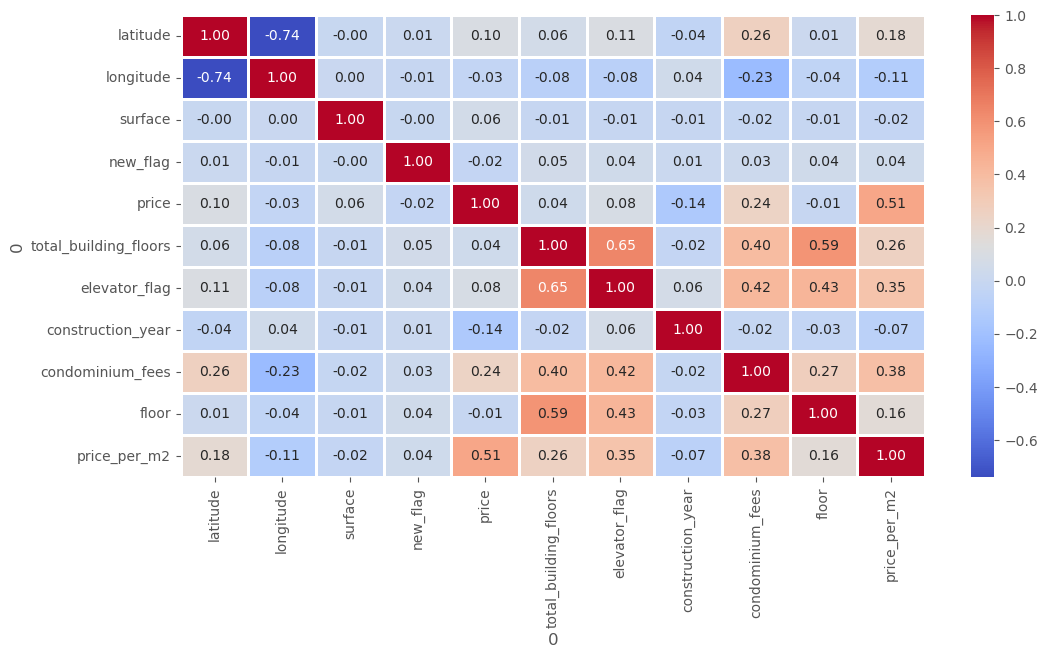

In [33]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(),
            cmap = 'coolwarm',
            fmt = '.2f',
            linewidths = 1,
            annot = True)

## Rooms and bathrooms columns

In [34]:
df.room.value_counts()

3     53740
4     38160
2     30964
5+    25964
5     20282
-1     5159
1      4431
Name: room, dtype: int64

In [35]:
five_plus = df[df.room == '5+']
five_plus.head(3)

,latitude,longitude,heating,air_conditioning,surface,new_flag,status,caption,price,room,property_class,category,total_building_floors,bathroom,elevator_flag,construction_year,title,condominium_fees,ownership,other_features,energy_efficiency,floor_text,floor,typology,visibility,Region,price_per_m2
0,37.6,15.0,Autonomo,NaN,200.0,0.0,Excellent condition / Renovated,Villa o villino in vendita a Mascalucia,310000,5+,Mid-range properties,Residential,3.0,3,0,1972.0,Villa unifamiliare via Busoni 5 Centro Mascalucia,0.0,Full ownership,"['Balcone', 'Giardino privato']",NaN,Su più livelli,NaN,Single-family villa,premium,Sicilia,1550.0
1,37.6,15.1,NaN,NaN,300.0,0.0,Needs renovation,Villa a Ficarazzi con ampio spazio esterno e l...,329000,5+,Luxury properties,Residential,2.0,2,0,1895.0,Villa unifamiliare via Tripoli 145 95021 Aci C...,0.0,Full ownership,"['Balcone', 'Terrazza', 'Impianto tv singolo',...",G,Piano terra,0.0,Single-family villa,premium,Sicilia,1096.7
3,37.7,14.9,Autonomo,"Autonomo, freddo/caldo",309.0,0.0,Needs renovation,Villa singola in vendita a Adrano,319000,5+,Mid-range properties,Residential,2.0,3,0,1986.0,Villa unifamiliare Contrada DUrso Adrano,0.0,Full ownership,"['Cancello elettrico', 'Caminetto', 'Porta bli...",G,Piano terra,0.0,Single-family villa,premium,Sicilia,1032.4


In [36]:
rooms=df[df.room == '1 - 4'] # typology "project"
rooms.head(3)

,latitude,longitude,heating,air_conditioning,surface,new_flag,status,caption,price,room,property_class,category,total_building_floors,bathroom,elevator_flag,construction_year,title,condominium_fees,ownership,other_features,energy_efficiency,floor_text,floor,typology,visibility,Region,price_per_m2


In [37]:
roomsminus = df[df.room == '-1']
roomsminus.head(2)

,latitude,longitude,heating,air_conditioning,surface,new_flag,status,caption,price,room,property_class,category,total_building_floors,bathroom,elevator_flag,construction_year,title,condominium_fees,ownership,other_features,energy_efficiency,floor_text,floor,typology,visibility,Region,price_per_m2
30,37.6,15.0,Autonomo,NaN,200.0,1.0,NaN,Not Available,315000,-1,NaN,Residential,3.0,-1,0,1972.0,Villa a schiera via Filippo Brunelleschi Centr...,NaN,Full ownership,"['1 Balcone', 'Terrazza', 'Piscina', 'Giardino...",NaN,"3 piani: da Seminterrato a Piano terra, Piano ...",0.0,Row house,Not Available,Sicilia,1575.0
54,37.2,14.6,Autonomo,NaN,300.0,0.0,Good condition / Habitable,Not Available,330000,-1,NaN,Residential,1.0,-1,0,1972.0,Villa bifamiliare via Luigi Einaudi 59 Grammic...,NaN,Full ownership,"['Piscina', 'Infissi esterni in vetro / metallo']",NaN,Piano terra,0.0,Two-family villa,Not Available,Sicilia,1100.0


https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8073340/    Published online 2021 Apr 17
### Minimum living area in Italy
The minimum area is 28 m2 for a single occupant in studio apartment

In [38]:
df = df[(df['surface'] >= 28)]

In [39]:
# converting values as '+5' and '1-4'
df['room'] = df['room'].replace('1 - 4', 1) #size-vise resembles studio ###################
df['room'] = df['room'].replace('5+', 6)
df['room'] = df['room'].replace('-1', 0)

In [40]:
df.room.value_counts()

3    53730
4    38159
2    30876
6    25964
5    20282
0     5116
1     3907
Name: room, dtype: int64

In [41]:
df['room']=df['room'].astype(float)

### What if we exclude out of scope and outliers defined previously

In [42]:
## Exclude  outliers
#Building and New constructions given the ranges of data and also the % of building and commercial is low
df= df[df['category'] == 'Residential']

df = df[(df['total_building_floors'] >= 0) & (df['total_building_floors'] <= 9)]

In [43]:
df.room.value_counts() # still almost 4400 properties with -1 room and 25 400 with 5+ rooms

3.0    53345
4.0    37821
2.0    30690
6.0    24932
5.0    20004
0.0     4296
1.0     3862
Name: room, dtype: int64

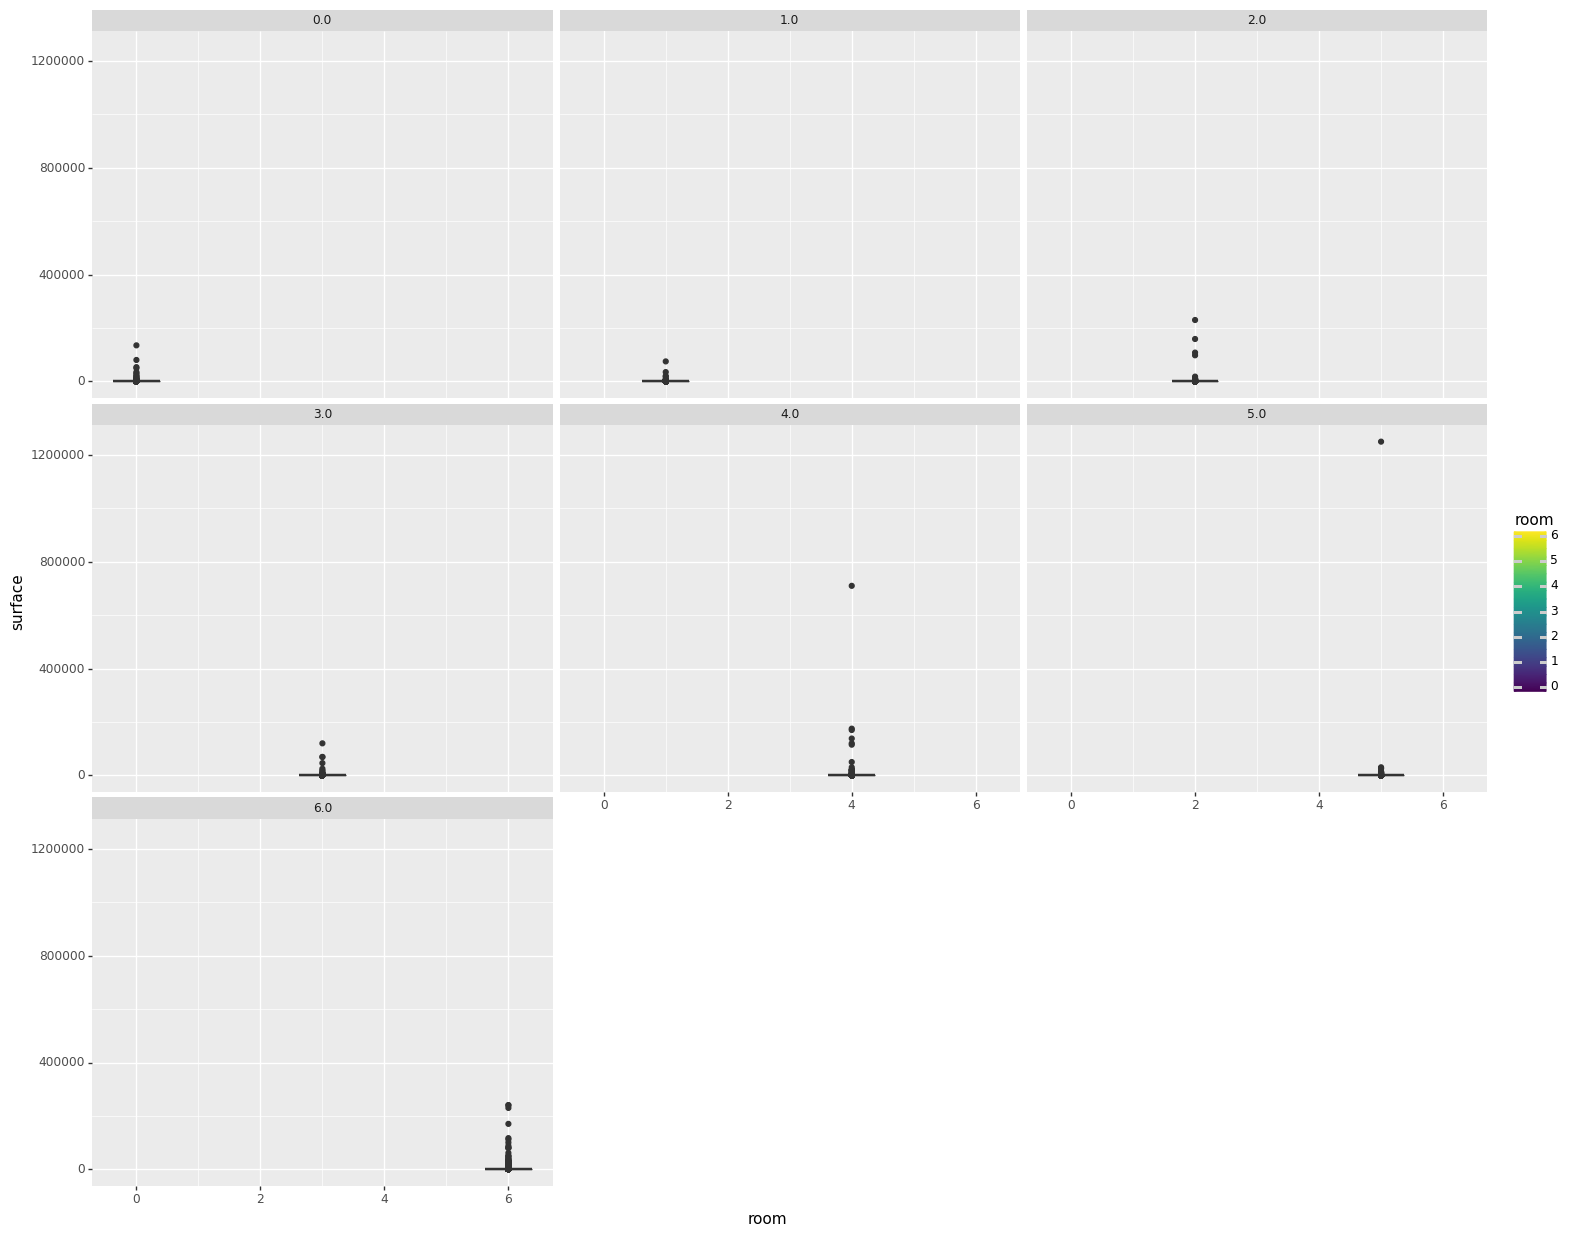

<ggplot: (108470827716)>

In [44]:
selected = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
(ggplot(df[df['room'].isin(selected)])
+aes(x='room', y= 'surface', fill = 'room')
+geom_boxplot()
+facet_wrap('room')
+ theme(figure_size= (18,15))
)

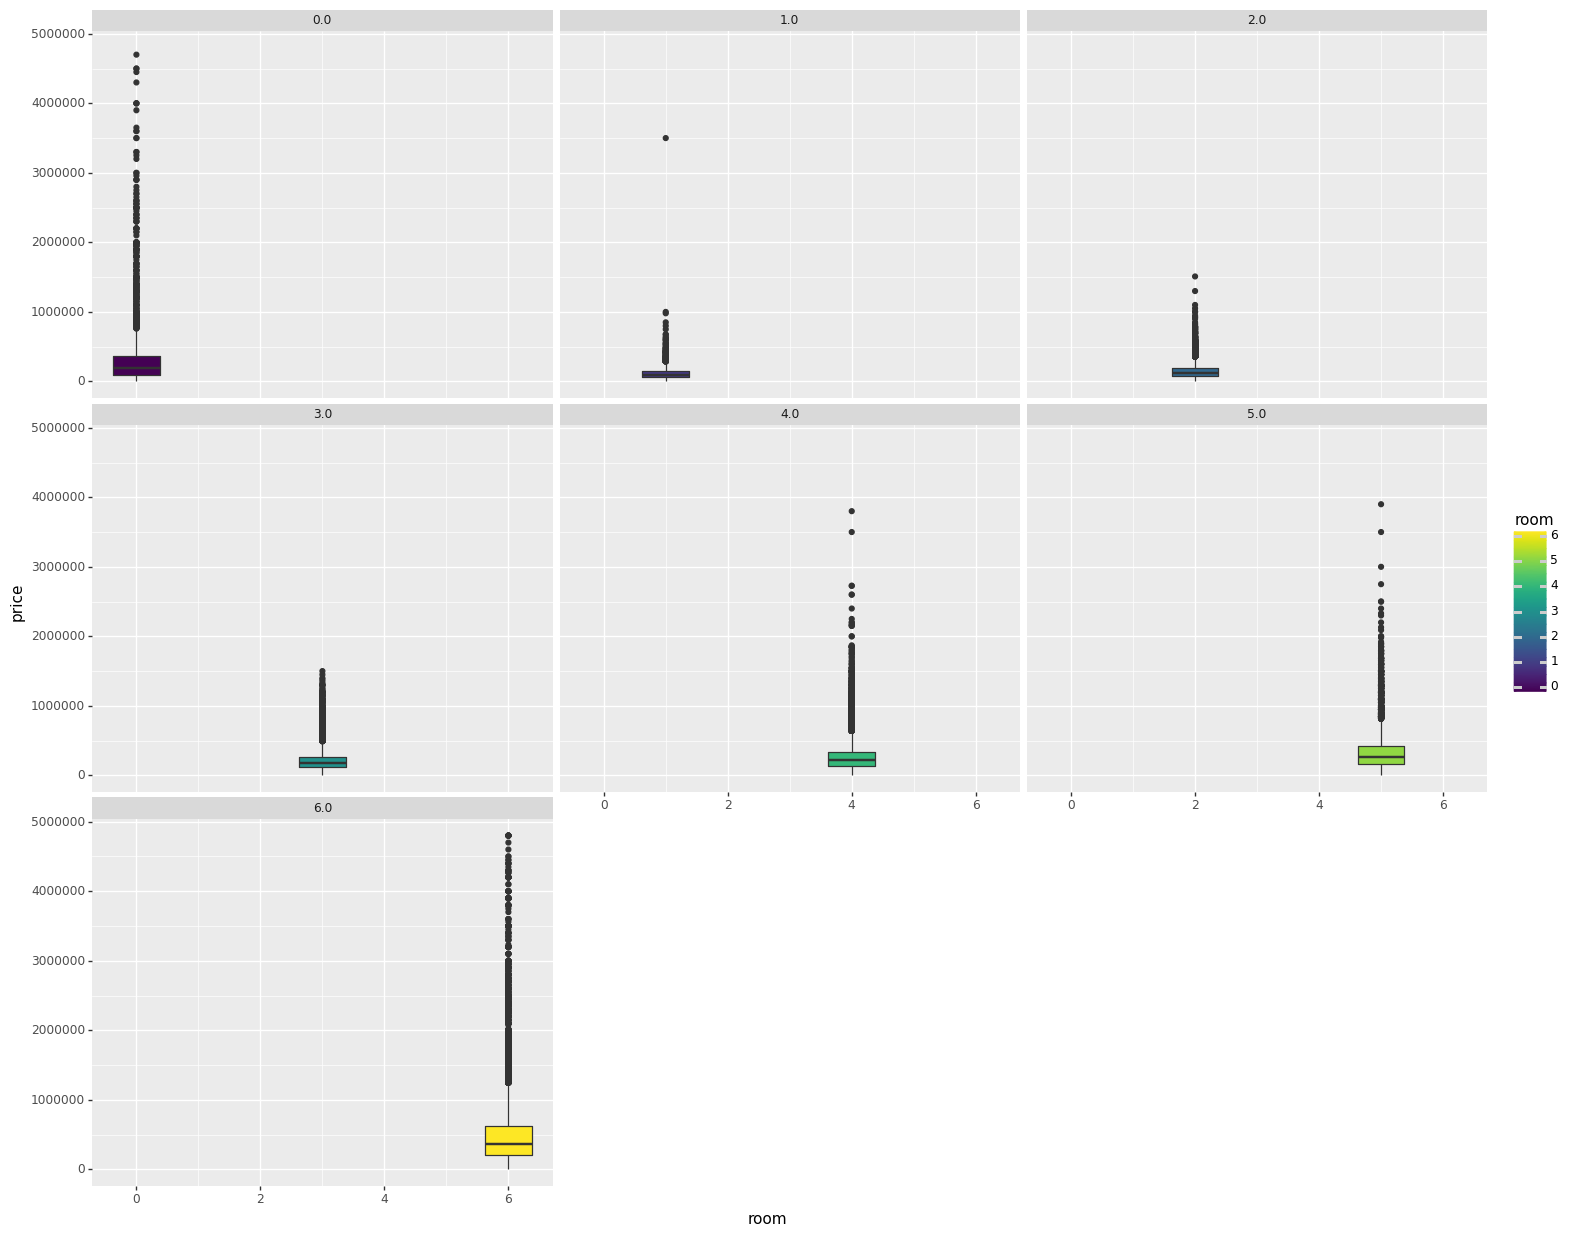

<ggplot: (108452977472)>

In [45]:
selected = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
(ggplot(df[df['room'].isin(selected)])
+aes(x='room', y= 'price', fill = 'room')
+geom_boxplot()
+facet_wrap('room')
+ theme(figure_size= (18,15))
)

### Both mode and median can work in the case of many outliers, however lets choose he median as it is less affected by extreme values and provides a robust estimate.

## lets find min , median and max surface for -1 rooms

In [46]:
#unidentified values
filtered_data = df[df['room'] == 0]
min_surface = filtered_data['surface'].min()
max_surface = filtered_data['surface'].max()
median_surface = filtered_data['surface'].median()

print(min_surface)
print(median_surface)
print(max_surface)

28.0
150.0
135135.0


In [47]:
#min, max and median without +5 and -1 values
filtered_data_all = df[(df['room'] != 6) & (df['room'] != 0)]
min_surface_all = filtered_data_all['surface'].min()
max_surface_all = filtered_data_all['surface'].max()
median_surface_all = filtered_data_all['surface'].median()
print(min_surface_all)
print(median_surface_all)
print(max_surface_all)

28.0
92.0
1250000.0


In [48]:
#min, max and median for 1 room
filtered_data = df[df['room'] == 1]
min_surface = filtered_data['surface'].min()
max_surface = filtered_data['surface'].max()
median_surface = filtered_data['surface'].median()

print(min_surface)
print(median_surface)
print(max_surface)

28.0
40.0
75000.0


In [49]:
# Filtered data within the range of 28 to 40 surface
filtered_data_range = filtered_data_all[
    (filtered_data_all['surface'] >= 28) &
    (filtered_data_all['surface'] <= 40)
]
median_rooms = filtered_data_range['room'].median()
mean_rooms = filtered_data_range['room'].mean()

print(median_rooms)
print(mean_rooms)

2.0
1.567167684358854


In [50]:
#min, max and median for 2 room
filtered_data = df[df['room'] == 2]
min_surface = filtered_data['surface'].min()
max_surface = filtered_data['surface'].max()
median_surface = filtered_data['surface'].median()

print(min_surface)
print(median_surface)
print(max_surface)

28.0
60.0
230100.0


In [51]:
#min, max and median for 3 room
filtered_data = df[df['room'] == 3]
min_surface = filtered_data['surface'].min()
max_surface = filtered_data['surface'].max()
median_surface = filtered_data['surface'].median()

print(min_surface)
print(median_surface)
print(max_surface)

30.0
88.0
120000.0


In [52]:
#min, max and median for 4 room
filtered_data = df[df['room'] == 4]
min_surface = filtered_data['surface'].min()
max_surface = filtered_data['surface'].max()
median_surface = filtered_data['surface'].median()

print(min_surface)
print(median_surface)
print(max_surface)

30.0
120.0
710000.0


In [53]:
#min, max and median for 5 room
filtered_data = df[df['room'] == 5]
min_surface = filtered_data['surface'].min()
max_surface = filtered_data['surface'].max()
median_surface = filtered_data['surface'].median()

print(min_surface)
print(median_surface)
print(max_surface)

40.0
150.0
1250000.0


In [54]:
for index, row in df.iterrows():
    if 28.0 <= row['surface'] <= 40.0:
        if row['room'] == 0:
            df.at[index, 'room'] = 1
    elif 41.0 <= row['surface'] <= 60.0:
        if row['room'] == 0:
            df.at[index, 'room'] = 2
    elif 61.0 <= row['surface'] <= 88.0:
        if row['room'] == 0:
            df.at[index, 'room'] = 3
    elif 89.0 <= row['surface'] <= 120.0:
        if row['room'] == 0:
            df.at[index, 'room'] = 4
    elif 121.0 <= row['surface'] <= 150.0:
        if row['room'] == 0:
            df.at[index, 'room'] = 5
    elif 151.0 <= row['surface'] <= 150000000.0:
        if row['room'] == 0:
            df.at[index, 'room'] = 6

In [55]:
df.room.value_counts()

3.0    53829
4.0    38594
2.0    30973
6.0    27075
5.0    20528
1.0     3951
Name: room, dtype: int64

In [56]:
df.head()

,latitude,longitude,heating,air_conditioning,surface,new_flag,status,caption,price,room,property_class,category,total_building_floors,bathroom,elevator_flag,construction_year,title,condominium_fees,ownership,other_features,energy_efficiency,floor_text,floor,typology,visibility,Region,price_per_m2
0,37.6,15.0,Autonomo,NaN,200.0,0.0,Excellent condition / Renovated,Villa o villino in vendita a Mascalucia,310000,6.0,Mid-range properties,Residential,3.0,3,0,1972.0,Villa unifamiliare via Busoni 5 Centro Mascalucia,0.0,Full ownership,"['Balcone', 'Giardino privato']",NaN,Su più livelli,NaN,Single-family villa,premium,Sicilia,1550.0
1,37.6,15.1,NaN,NaN,300.0,0.0,Needs renovation,Villa a Ficarazzi con ampio spazio esterno e l...,329000,6.0,Luxury properties,Residential,2.0,2,0,1895.0,Villa unifamiliare via Tripoli 145 95021 Aci C...,0.0,Full ownership,"['Balcone', 'Terrazza', 'Impianto tv singolo',...",G,Piano terra,0.0,Single-family villa,premium,Sicilia,1096.7
3,37.7,14.9,Autonomo,"Autonomo, freddo/caldo",309.0,0.0,Needs renovation,Villa singola in vendita a Adrano,319000,6.0,Mid-range properties,Residential,2.0,3,0,1986.0,Villa unifamiliare Contrada DUrso Adrano,0.0,Full ownership,"['Cancello elettrico', 'Caminetto', 'Porta bli...",G,Piano terra,0.0,Single-family villa,premium,Sicilia,1032.4
8,37.6,14.9,Autonomo,"Autonomo, freddo/caldo",250.0,0.0,Excellent condition / Renovated,Elegantissimo appartamento 250mq in centro a P...,325000,6.0,NaN,Residential,3.0,3,1,2017.0,Appartamento via Gian Battista Nicolosi 342 Pa...,NaN,Full ownership,"['Impianto di allarme', 'Porta blindata', 'Arm...",B,"2°, con ascensore",2.0,Apartment,premium,Sicilia,1300.0
9,37.6,14.9,Autonomo,"Autonomo, freddo/caldo",200.0,0.0,Excellent condition / Renovated,Elegantissimo appartamento 217mq in centro a P...,319000,6.0,NaN,Residential,3.0,2,1,2017.0,Appartamento via Gian Battista Nicolosi 342 Pa...,NaN,Full ownership,"['Impianto di allarme', 'Porta blindata', 'Arm...",B,"2°, con ascensore",2.0,Apartment,premium,Sicilia,1595.0


C:\Users\kater\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


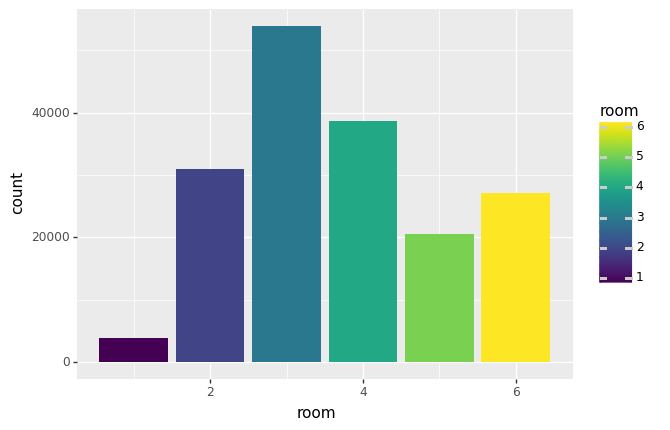

<ggplot: (108505586348)>

In [57]:
(ggplot(df)
 +aes(x='room', fill='room', group='room')
 +geom_bar(position = 'dodge')
 +geom_line(stat = 'count')
)

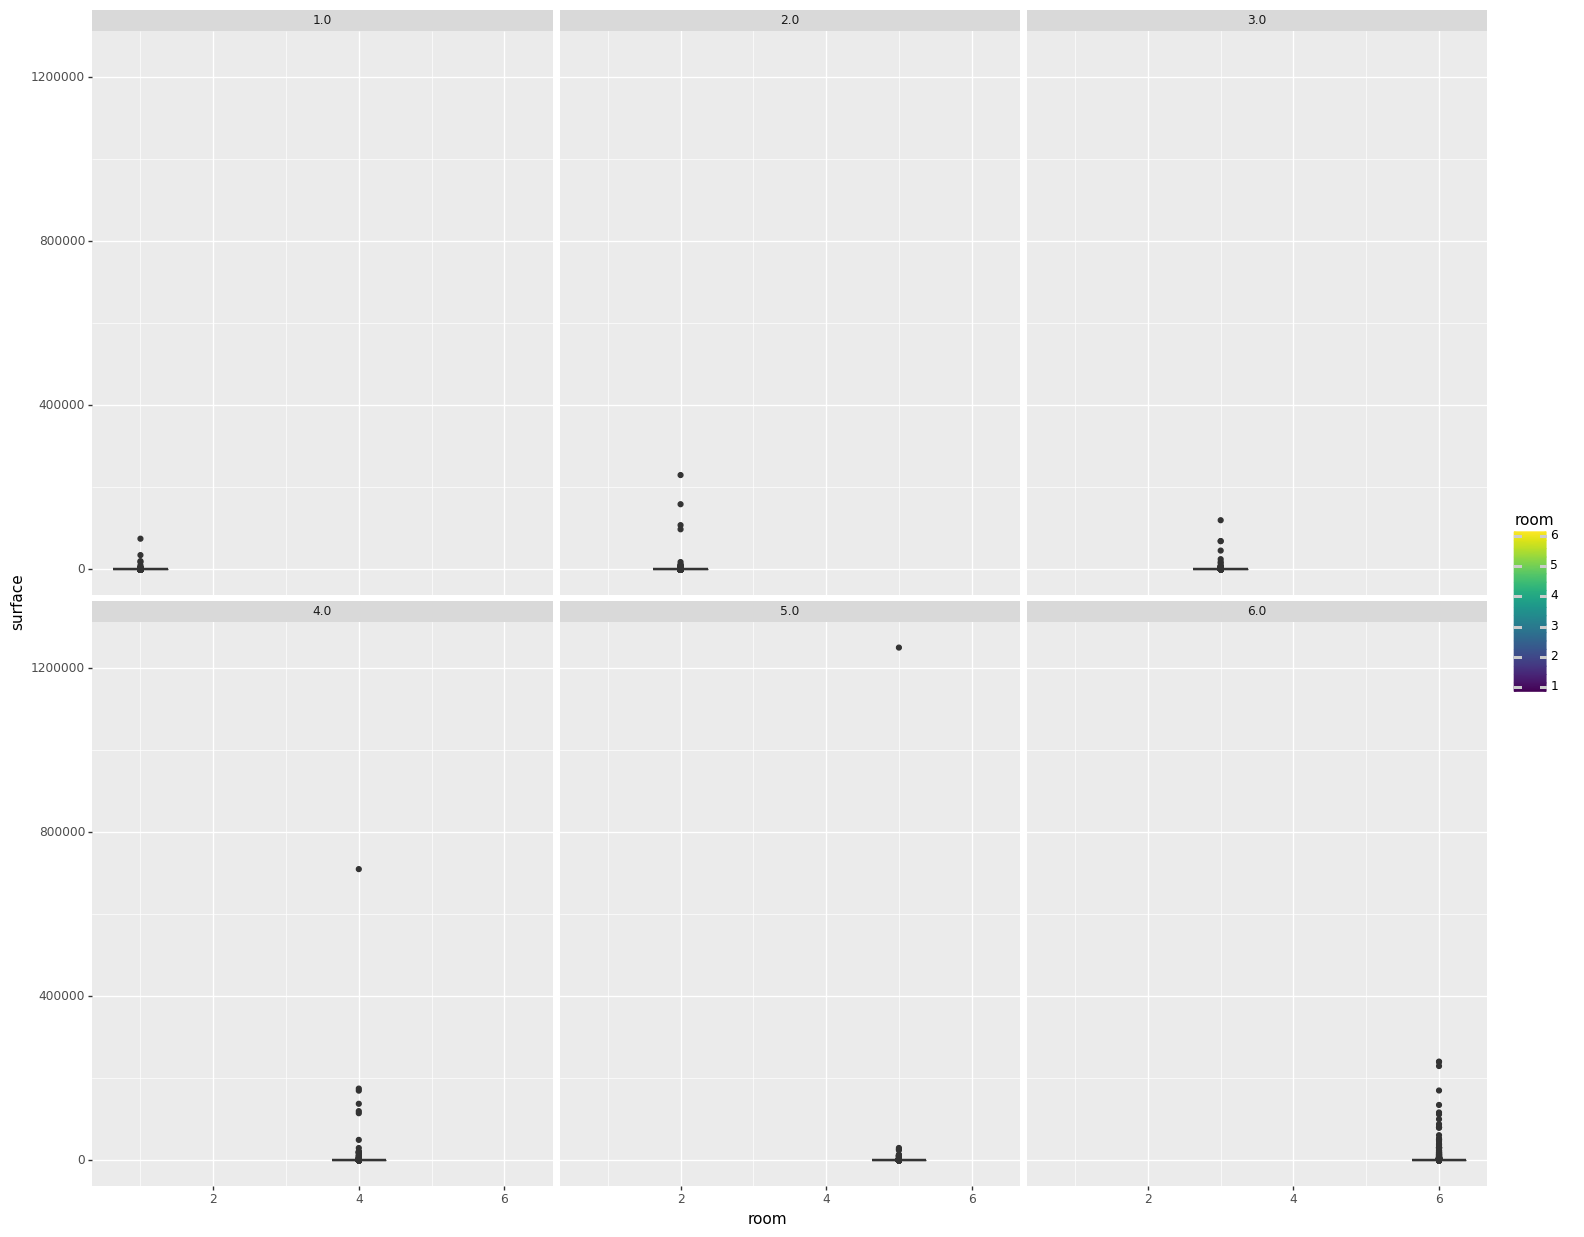

<ggplot: (108476440411)>

In [58]:
selected = [1, 2, 3, 4, 5, 6]
(ggplot(df[df['room'].isin(selected)])
+aes(x='room', y= 'surface', fill = 'room')
+geom_boxplot()
+facet_wrap('room')
+ theme(figure_size= (18,15))
)

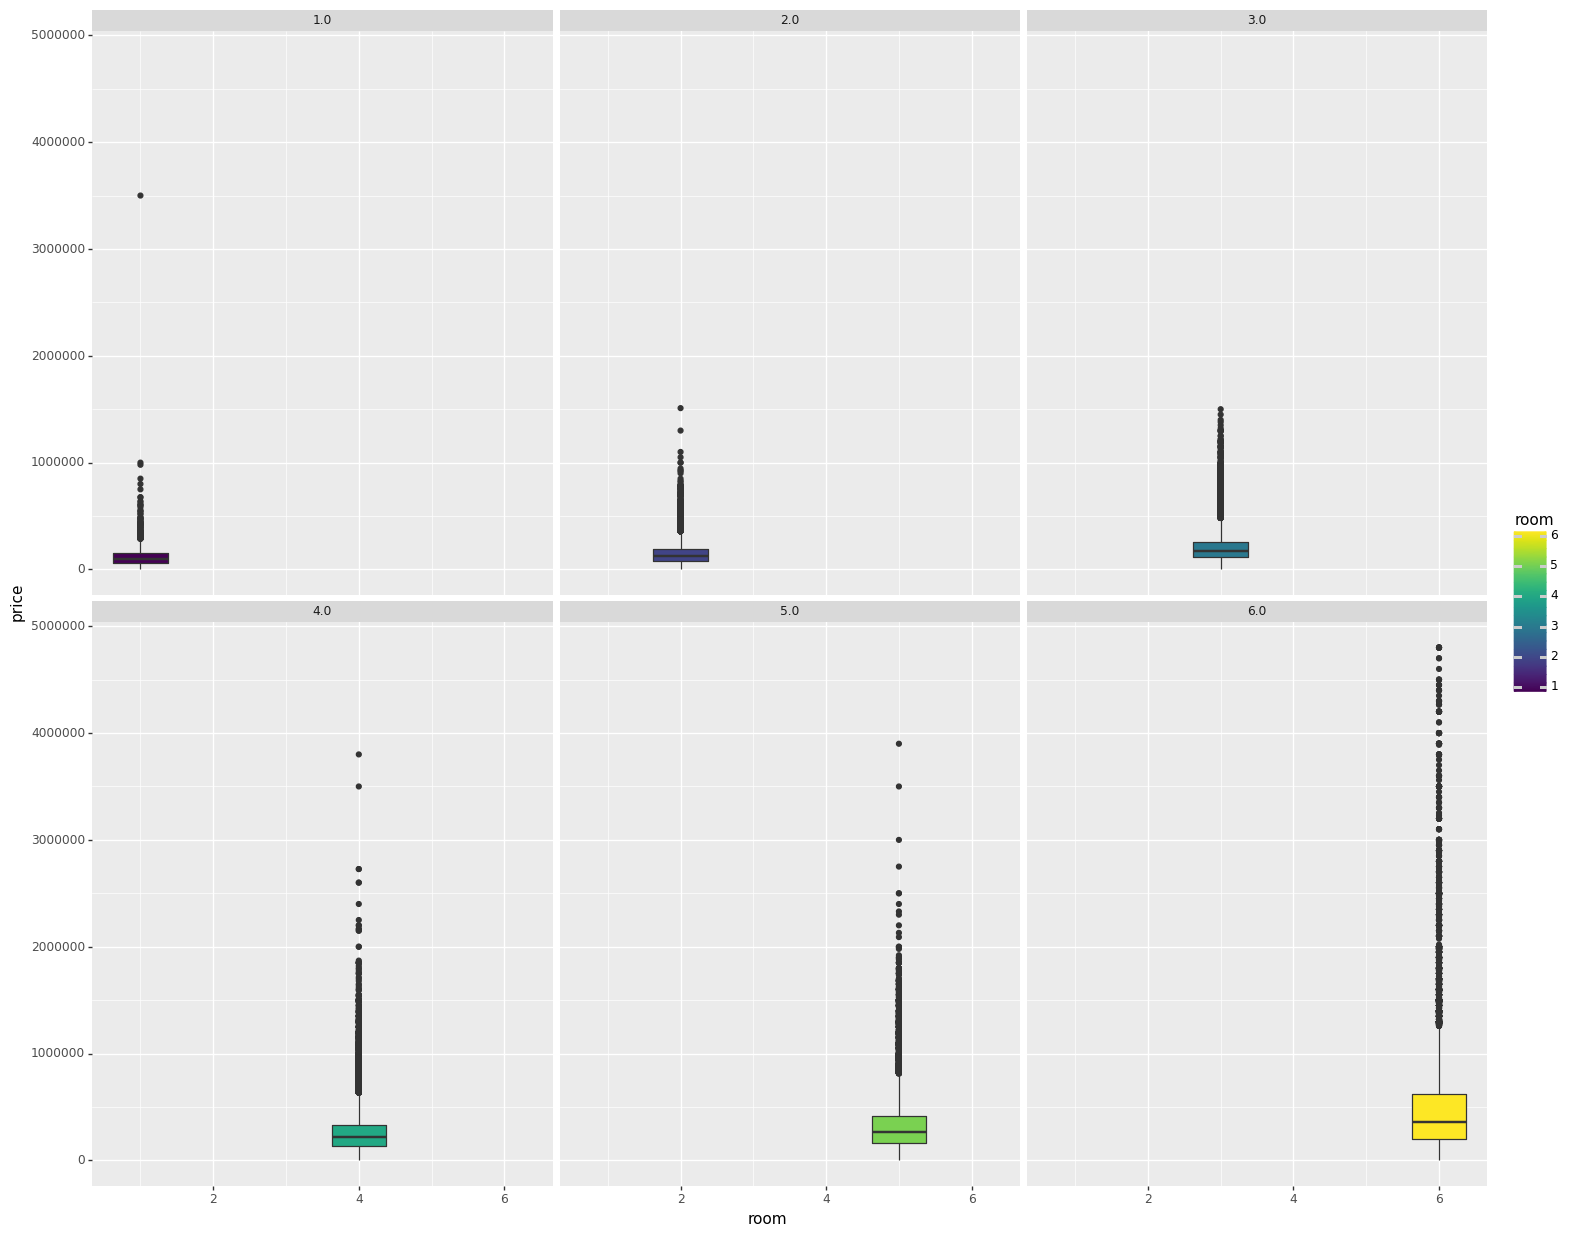

<ggplot: (108477160406)>

In [59]:
selected = [1, 2, 3, 4, 5, 6]
(ggplot(df[df['room'].isin(selected)])
+aes(x='room', y= 'price', fill = 'room')
+geom_boxplot()
+facet_wrap('room')
+ theme(figure_size= (18,15))
)

<AxesSubplot:xlabel='0', ylabel='0'>

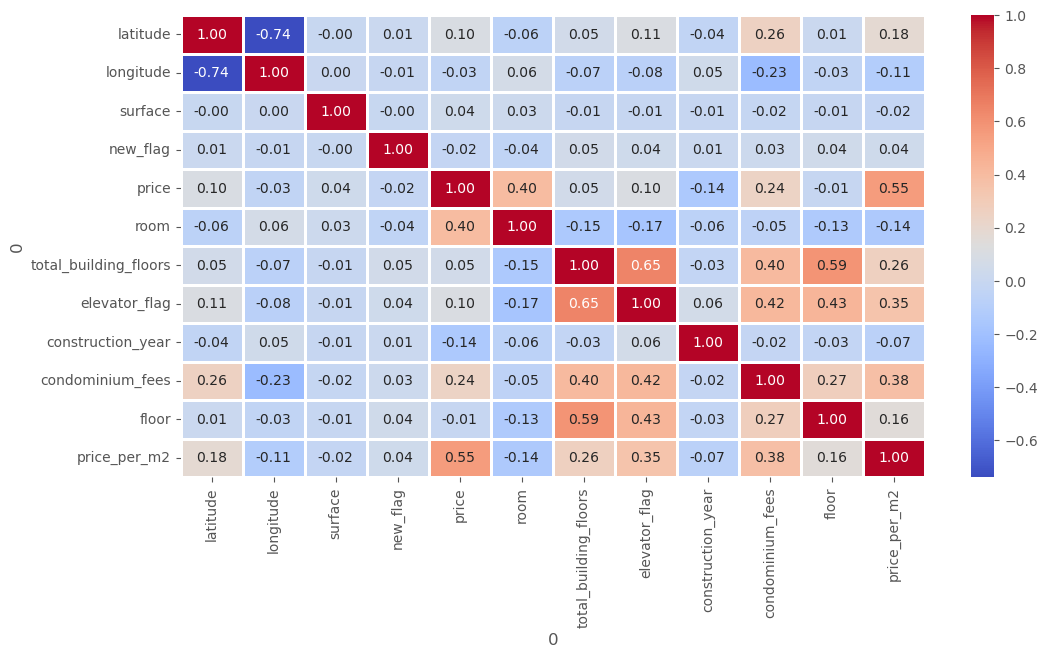

In [60]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(),
            cmap = 'coolwarm',
            fmt = '.2f',
            linewidths = 1,
            annot = True)

# Bathroom

Lets apply the same approach to Bathroom column

In [61]:
df.bathroom.value_counts()

1     88953
2     60857
3     13916
3+     7464
-1     3760
Name: bathroom, dtype: int64

In [62]:
df['bathroom'] = df['bathroom'].replace('3+', 4)
df['bathroom'] = df['bathroom'].replace('-1', 0)

In [63]:
df['bathroom']=df['bathroom'].astype(float)

In [64]:
df.bathroom.value_counts()

1.0    88953
2.0    60857
3.0    13916
4.0     7464
0.0     3760
Name: bathroom, dtype: int64

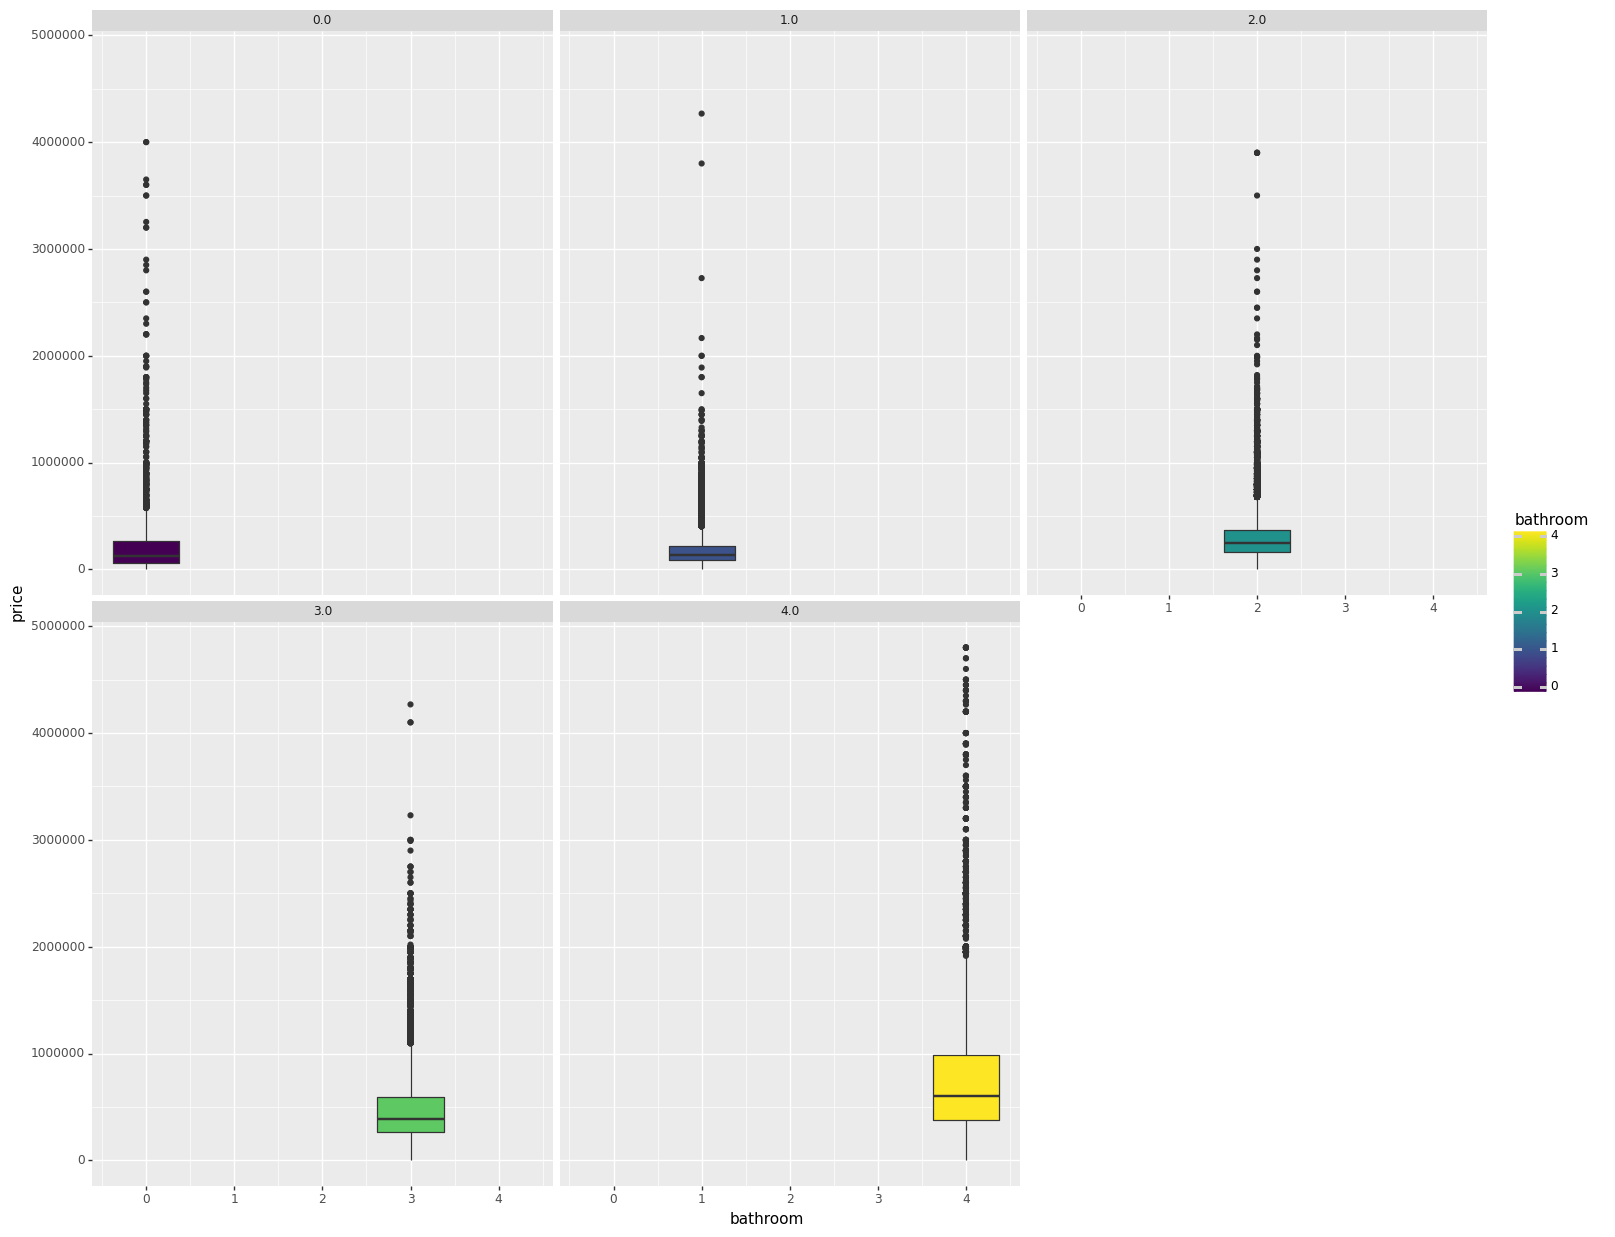

<ggplot: (108473383421)>

In [65]:
selected = [0.0, 1.0, 2.0, 3.0, 4.0]
(ggplot(df[df['bathroom'].isin(selected)])
+aes(x='bathroom', y= 'price', fill = 'bathroom')
+geom_boxplot()
+facet_wrap('bathroom')
+ theme(figure_size= (18,15))
)

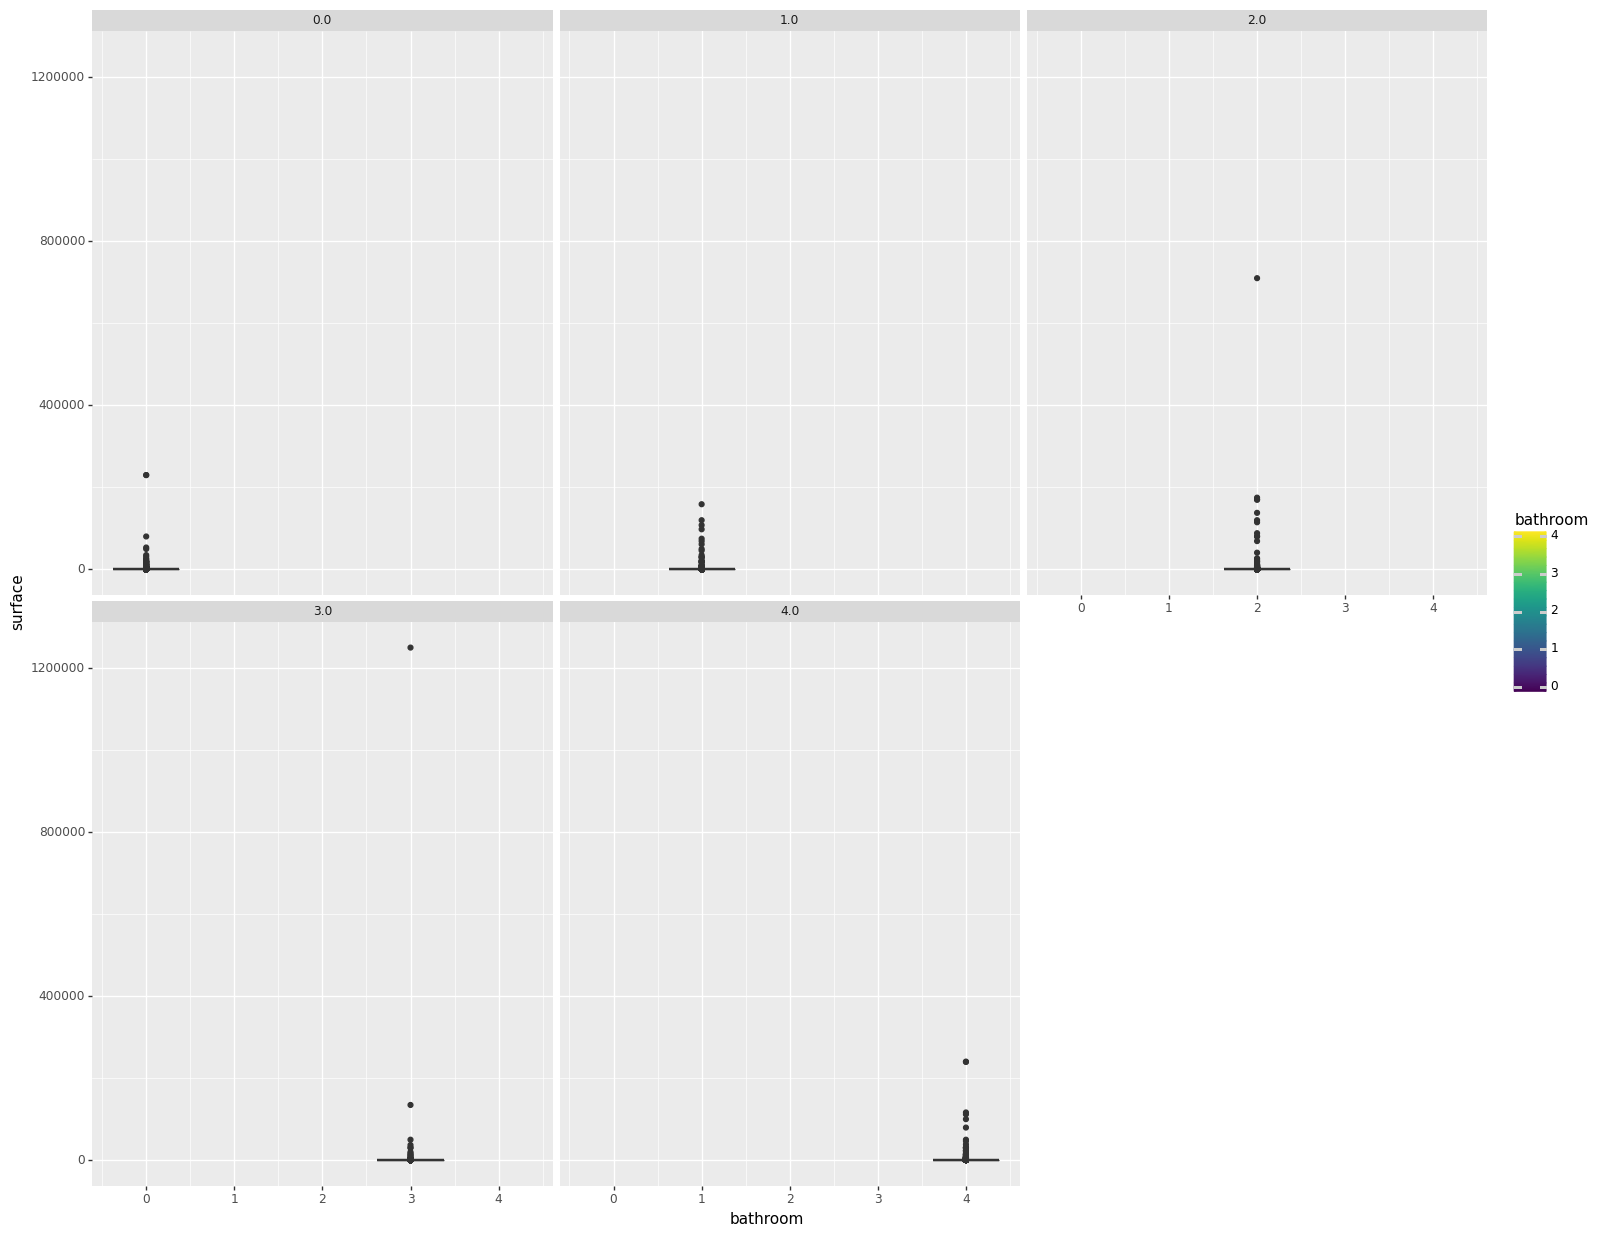

<ggplot: (108475488648)>

In [66]:
selected = [0.0, 1.0, 2.0, 3.0, 4.0]
(ggplot(df[df['bathroom'].isin(selected)])
+aes(x='bathroom', y= 'surface', fill = 'bathroom')
+geom_boxplot()
+facet_wrap('bathroom')
+ theme(figure_size= (18,15))
)

## Min, max, amd median for -1 bathrooms

In [67]:
filtered_d = df[df['bathroom'] == 0]
min_surface = filtered_d['surface'].min()
max_surface = filtered_d['surface'].max()
median_surface = filtered_d['surface'].median()

print(min_surface)
print(median_surface)
print(max_surface)

28.0
123.0
230100.0


In [68]:
#min, max and median without +3 and -1 values
filtered_d_all = df[(df['bathroom'] != 4) & (df['bathroom'] != 0)]
min_surface_all = filtered_d_all['surface'].min()
max_surface_all = filtered_d_all['surface'].max()
median_surface_all = filtered_d_all['surface'].median()
print(min_surface_all)
print(median_surface_all)
print(max_surface_all)

28.0
100.0
1250000.0


In [69]:
filtered_d = df[df['bathroom'] == 1.0]
min_surface = filtered_d['surface'].min()
max_surface = filtered_d['surface'].max()
median_surface = filtered_d['surface'].median()

print(min_surface)
print(median_surface)
print(max_surface)

28.0
77.0
159000.0


In [70]:
filtered_d = df[df['bathroom'] == 2.0]
min_surface = filtered_d['surface'].min()
max_surface = filtered_d['surface'].max()
median_surface = filtered_d['surface'].median()

print(min_surface)
print(median_surface)
print(max_surface)

30.0
125.0
710000.0


In [71]:
filtered_d = df[df['bathroom'] == 3.0]
min_surface = filtered_d['surface'].min()
max_surface = filtered_d['surface'].max()
median_surface = filtered_d['surface'].median()

print(min_surface)
print(median_surface)
print(max_surface)

50.0
207.0
1250000.0


In [72]:
filtered_d = df[df['bathroom'] == 4.0]
min_surface = filtered_d['surface'].min()
max_surface = filtered_d['surface'].max()
median_surface = filtered_d['surface'].median()

print(min_surface)
print(median_surface)
print(max_surface)

40.0
350.0
240700.0


In [73]:
for index, row in df.iterrows():
    if 28.0 <= row['surface'] <= 77.0:
        if row['bathroom'] == 0:
            df.at[index, 'bathroom'] = 1
    elif 78.0 <= row['surface'] <= 125.0:
        if row['bathroom'] == 0:
            df.at[index, 'bathroom'] = 2
    elif 126.0 <= row['surface'] <= 205.0:
        if row['bathroom'] == 0:
            df.at[index, 'bathroom'] = 3
    elif 206.0 <= row['surface'] <= 20000000.0:
        if row['bathroom'] == 0:
            df.at[index, 'bathroom'] = 4

<AxesSubplot:xlabel='0', ylabel='0'>

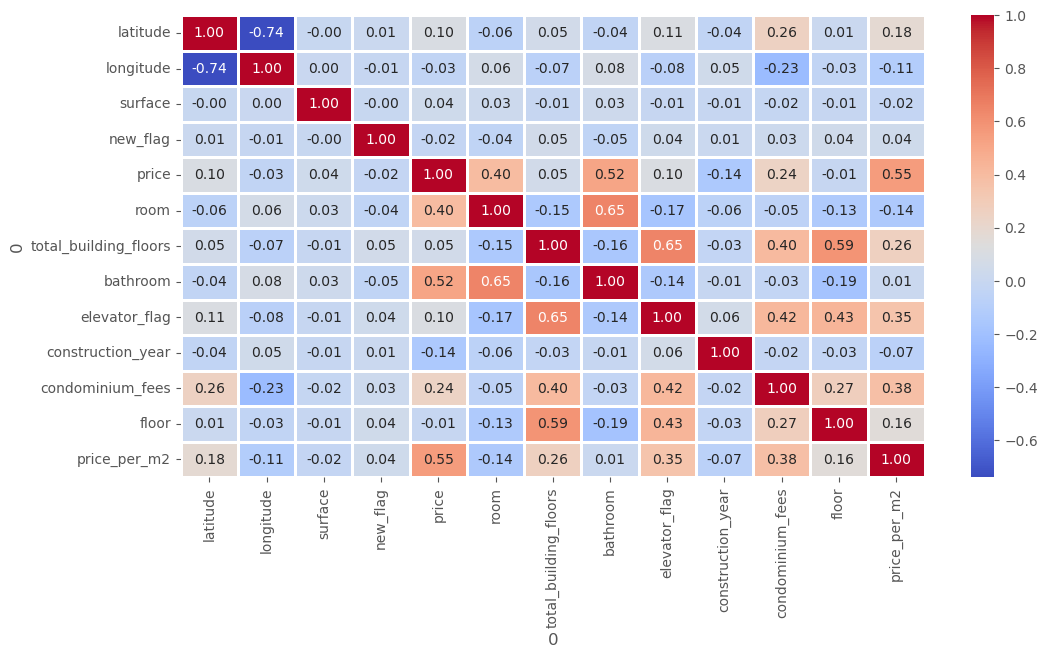

In [74]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(),
            cmap = 'coolwarm',
            fmt = '.2f',
            linewidths = 1,
            annot = True)

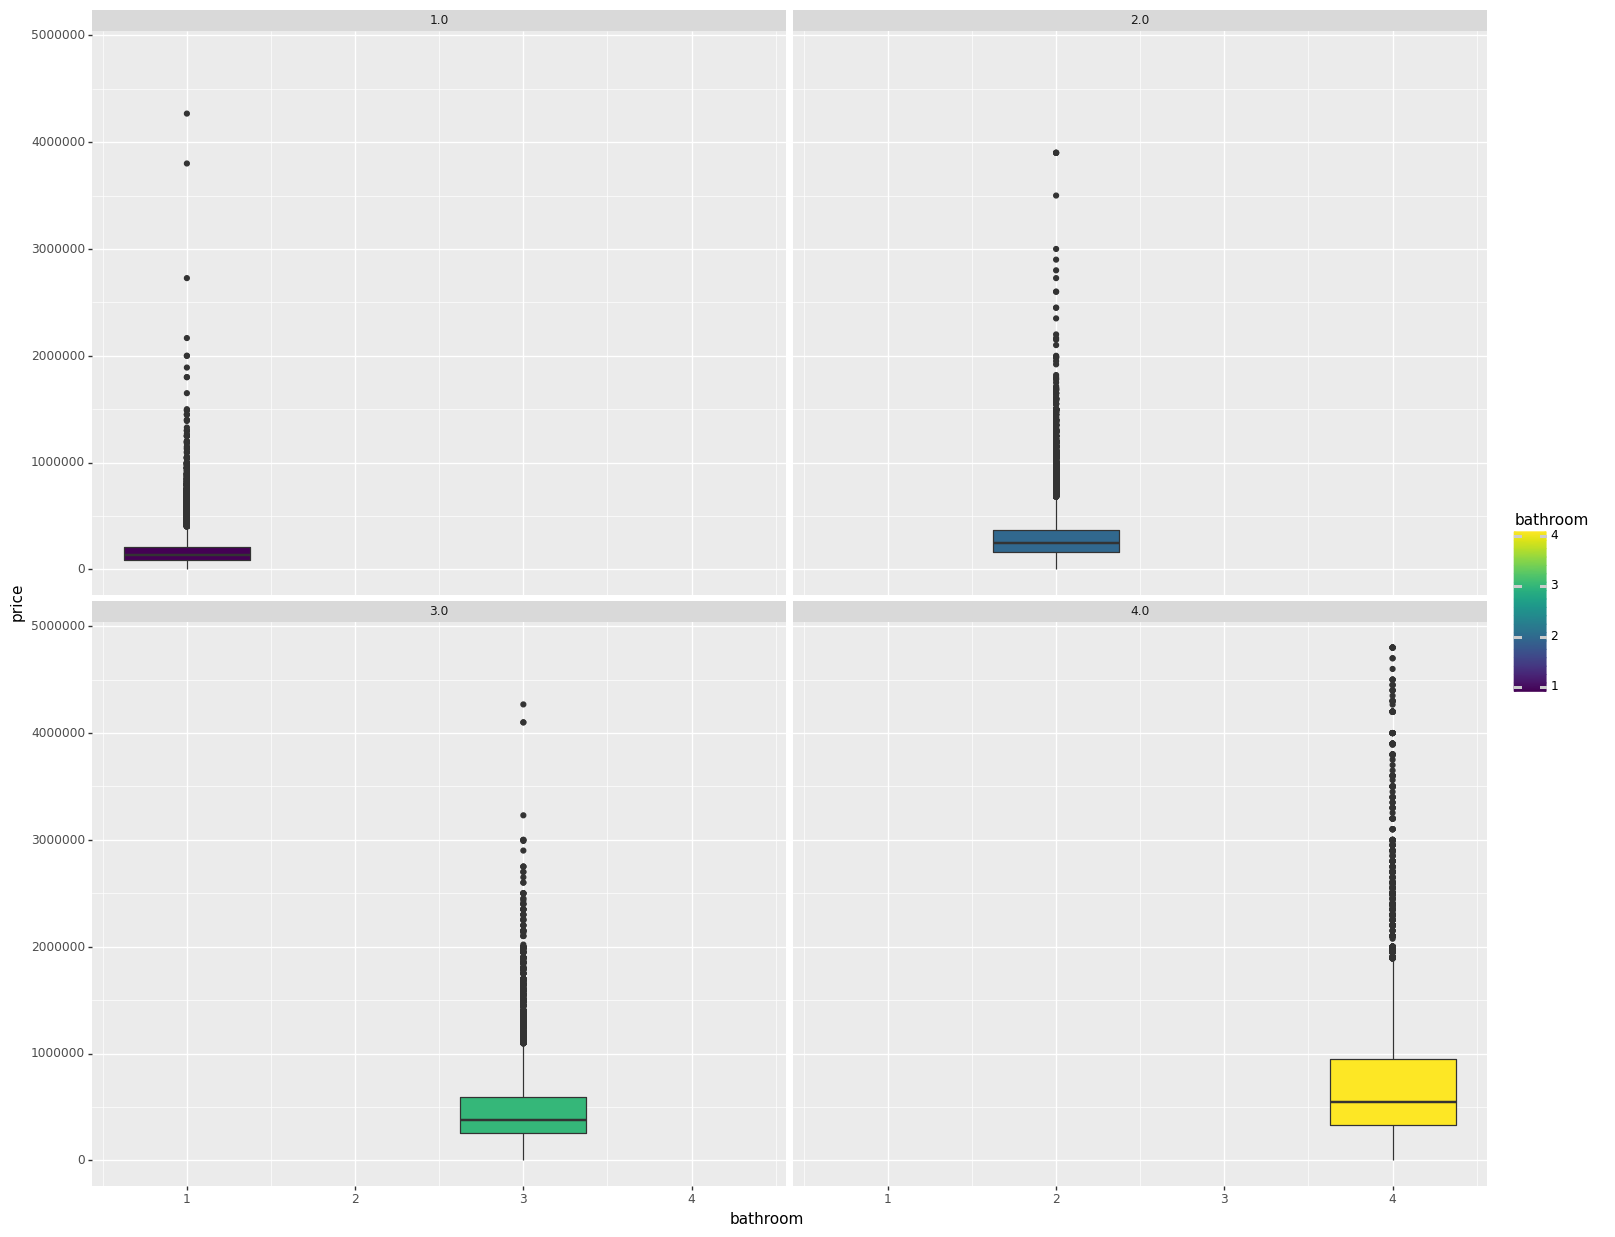

<ggplot: (108475749840)>

In [75]:
selected = [1.0, 2.0, 3.0, 4.0]
(ggplot(df[df['bathroom'].isin(selected)])
+aes(x='bathroom', y= 'price', fill = 'bathroom')
+geom_boxplot()
+facet_wrap('bathroom')
+ theme(figure_size= (18,15))
)

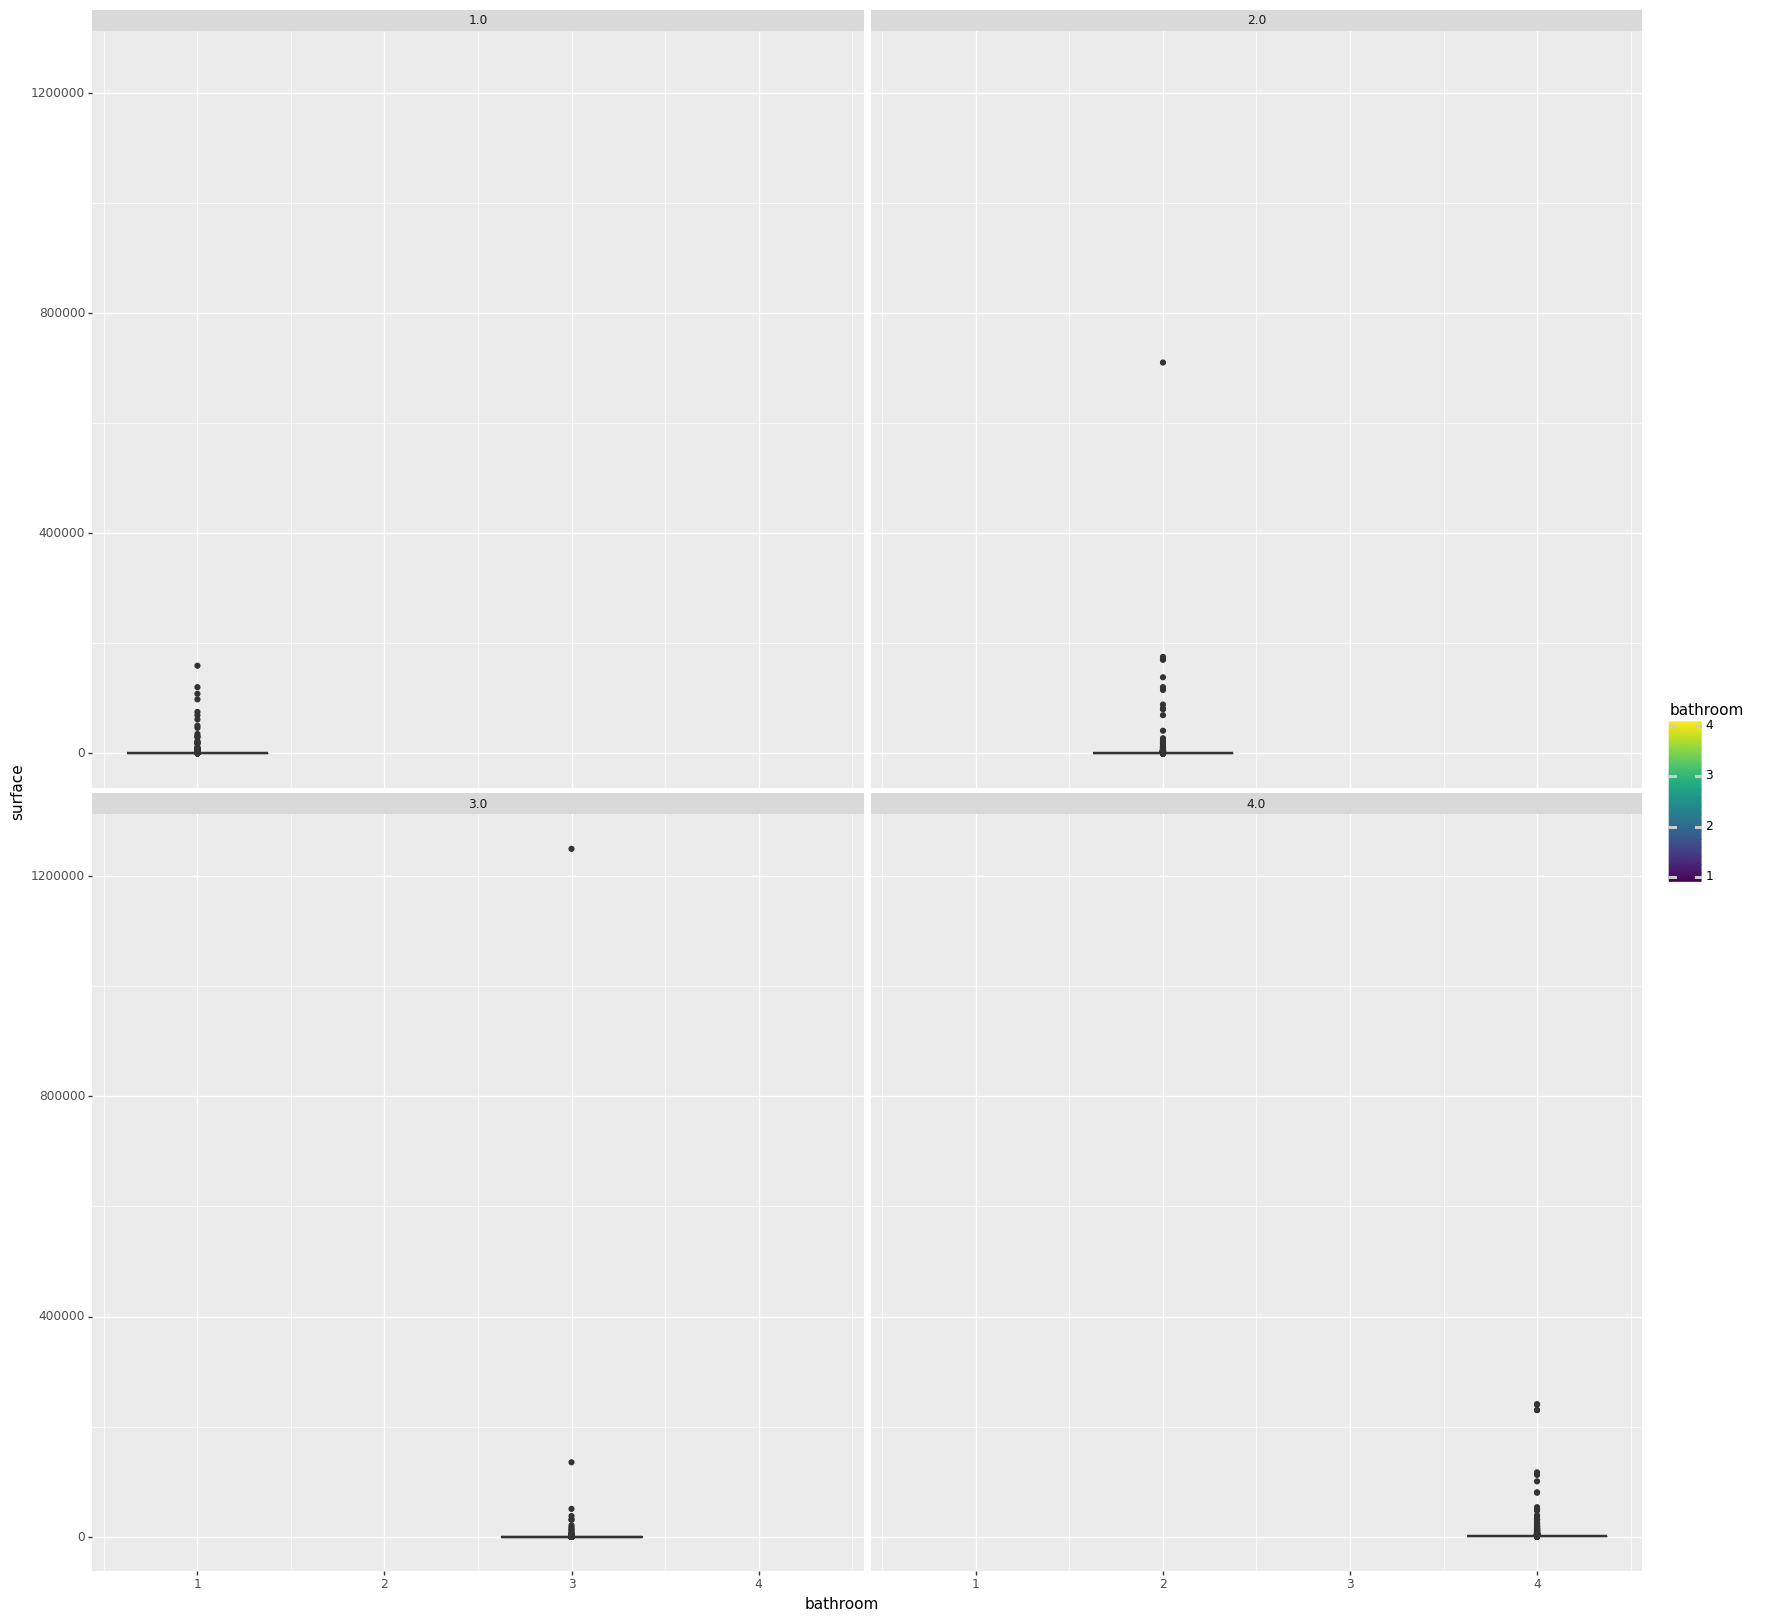

<ggplot: (108453067710)>

In [76]:
selected = [1.0, 2.0, 3.0, 4.0]
(ggplot(df[df['bathroom'].isin(selected)])
+aes(x='bathroom', y= 'surface', fill = 'bathroom')
+geom_boxplot()
+facet_wrap('bathroom')
+ theme(figure_size= (20,20))
)

'A' represents the most efficient level and 'G' represents the least efficient level in dataset. We will assign numerical values in ascending order, where 'A' is assigned the highest numerical value (e.g., 7) and 'G' is assigned the lowest numerical value (e.g., 1). 

**Lets explore new correlations in order to anderstand better how to deal with NaN values**

# Average income per region
# Population per region

**Note:**

Data source: http://dati.istat.it/?lang=en#

Income data from 2020

Data on population Jan 2023

In [77]:
people = pd.read_excel('income and population.xlsx') 
people.head()

,Region,annual_avr_houshold_income,population
0,Lombardy,40858,9950742
1,Veneto,37529,4838253
2,Liguria,34806,1502624
3,Emilia-Romagna,40039,4426929
4,Toscana,37288,3651152


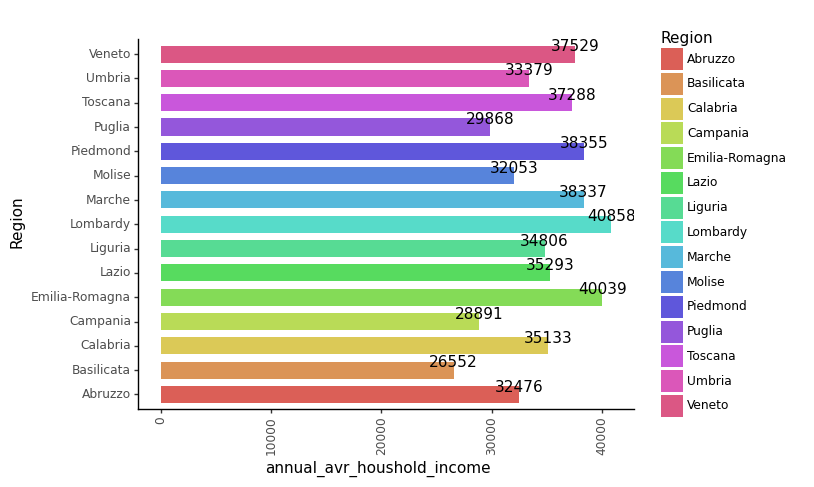

<ggplot: (108496928272)>

In [78]:
(ggplot(people)
 +aes(x='Region', y = 'annual_avr_houshold_income', fill = 'Region')
 +geom_bar(stat='identity', width = 0.7)
 +theme_classic()
 +theme(axis_text_x= element_text(rotation=90))
 +geom_text(aes(label='annual_avr_houshold_income'),va ='bottom')
 +coord_flip()
)

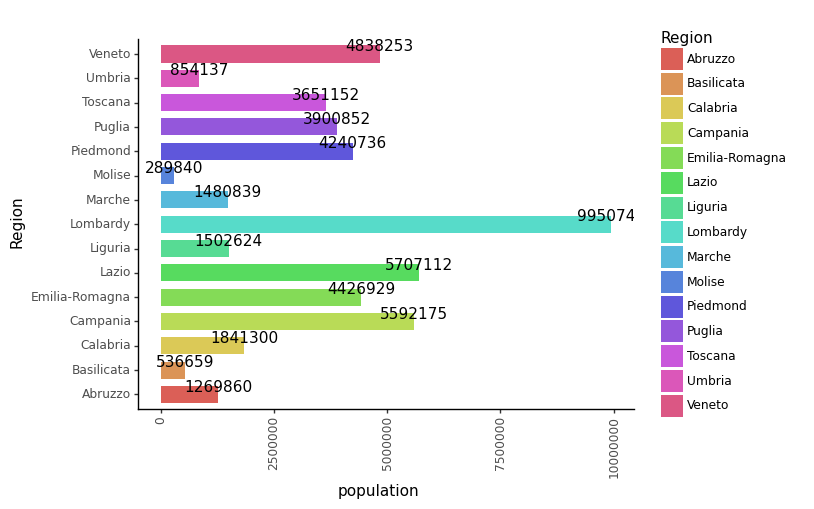

<ggplot: (108453089759)>

In [79]:
(ggplot(people)
 +aes(x='Region', y = 'population', fill = 'Region')
 +geom_bar(stat='identity', width = 0.7)
 +theme_classic()
 +theme(axis_text_x= element_text(rotation=90))
 +geom_text(aes(label='population'),va ='bottom')
 +coord_flip()
)